In [1]:
import numpy as np
from scipy import linalg
import scipy.io as sio
import random
from statistics import mean
from math import pi, sin, cos

from PIL import Image

from API.camera import Camera
from API.functions3D import *
from API.linear_solver import *
from API.nonlinear_solver import *
from API.utils import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d

import pickle

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
array_object=np.load('NPZ/transformed_point_cloud_array_skeleton.npz')

transformed_point_cloud_arr_npz=array_object['transformed_point_cloud_array']
point_cloud_arr_npz=array_object['point_cloud_array']
box_sides=array_object['dist']

In [3]:
# Downsample points in the point cloud

downsampled_dataset_size = 1000
downsampled_dataset=random_downsampler(point_cloud_arr_npz, downsampled_dataset_size)

x_component=extract_orthogonal_component(downsampled_dataset, 0)
y_component=extract_orthogonal_component(downsampled_dataset, 1)
z_component=extract_orthogonal_component(downsampled_dataset, 2)

Downsampled dataset size: 1000


In [4]:
num_points = downsampled_dataset_size

P_x_array = x_component
P_y_array = y_component
P_z_array = z_component

P_array = np.zeros((num_points, 3))

for index in range(num_points):
    P_array[index] = np.array([P_x_array[index], P_y_array[index], P_z_array[index]])

Text(0.5, 0, 'Z_axis')

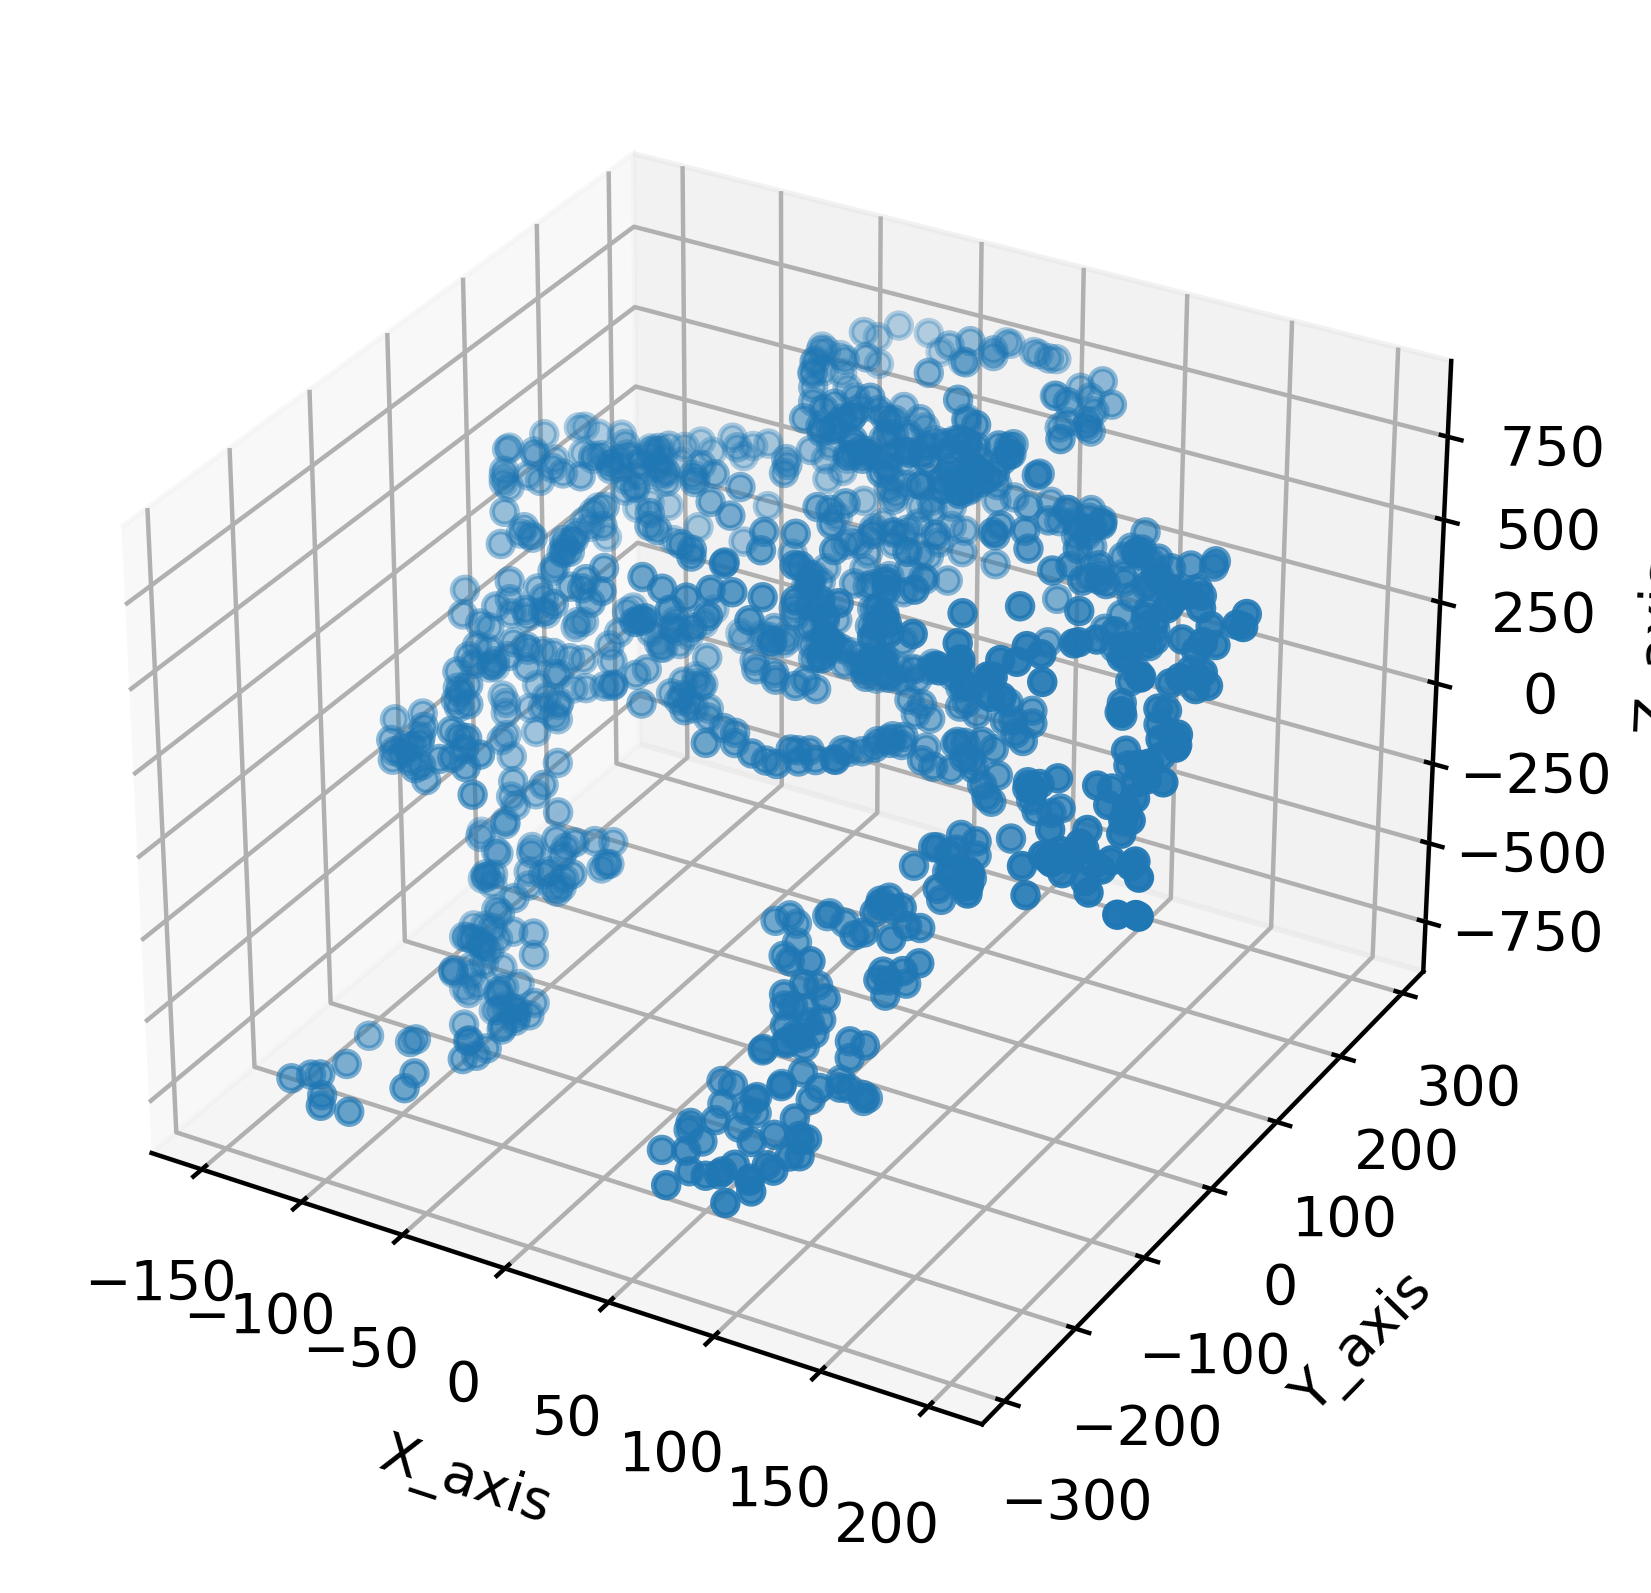

In [5]:
# Visualize P in 3D plot

fig = plt.figure(dpi=400)
ax_3d = fig.add_subplot(projection='3d')

ax_3d.scatter(P_array[:, 0], P_array[:, 1], P_array[:, 2], ".")

ax_3d.set_xlabel("X_axis")
ax_3d.set_ylabel("Y_axis")
ax_3d.set_zlabel("Z_axis")

Camera Configurations

In [6]:
num_cameras = 6

# z (Camera Distance along the z-axis, outside the bounding box (Can be a random value))
z = 6*max(box_sides)

# The Cameras are homogeneous, so keep the intrinsic parameters the same
f = 1
z0 = 1
k = 1
l =1
c_x = 2.5
c_y = 0.3

alpha_array = [0, 0, 0, 0, 0, 0]
beta_array = [0, np.pi/4, 3*np.pi/4, np.pi, 5*np.pi/4, 7*np.pi/4]
gamma_array = [0, 0, 0, 0, 0, 0]

x_array = [0, z/np.sqrt(2), z/np.sqrt(2), 0, -z/np.sqrt(2), -z/np.sqrt(2)]
y_array = [0, 0, 0, 0, 0, 0]
z_array = [z, z/np.sqrt(2), -z/np.sqrt(2), -z, -z/np.sqrt(2), z/np.sqrt(2)]

Visualize the camera setuup in 3D space

In [7]:
# Visualize P in 3D plot

elev=0
azim=90
roll=0

fig = plt.figure(dpi=400)
ax_3d = fig.add_subplot(projection='3d')
ax_3d.view_init(elev, azim, roll)

ax_3d.scatter(P_array[:, 0], P_array[:, 1], P_array[:, 2], ".", color="green")

ax_3d.set_xlabel("X_axis")
ax_3d.set_ylabel("Y_axis")
ax_3d.set_zlabel("Z_axis")

ax_3d.grid(True)

ax_3d.set_xticklabels([])
ax_3d.set_yticklabels([])
ax_3d.set_zticklabels([])

ax_3d.scatter(x_array, y_array, z_array, ".", color="blue")

u_array = []
v_array = []
for beta_idx in range(len(beta_array)):
    u_array.append(-cos(beta_array[beta_idx]))
    v_array.append(-sin(beta_array[beta_idx]))

for i in range(len(x_array)):
    ax_3d.quiver(x_array[i], y_array[i], z_array[i], v_array[i], 0, u_array[i], length = 5000, normalize = True, color="red")

Setting up camera dictionary

In [8]:
camera_dict = {}

for idx in range(num_cameras):
    cam = Camera(idx+1)
    cam.set_intrinsic_matrix_params(f, z0, k, l, c_x, c_y)

    # Ground to Camera Perspective (Have to invert the Rotation and Translation values)
    cam.set_extrinsic_rot_matrix_params(-alpha_array[idx], -beta_array[idx], -gamma_array[idx])
    cam.set_extrinsic_translation_matrix_params(-x_array[idx], -y_array[idx], -z_array[idx])

    rotation_matrix = cam.get_3D_rotation_matrix()
    translation_matrix = cam.get_3D_translation_matrix()
    intrinsic_matrix = cam.get_intrinsic_matrix()

    camera_dict.update({idx : {"Camera ID": cam.camera_id, "Camera Obj": cam, 
                                 "Camera Matrix": cam.get_camera_matrix(intrinsic_matrix, rotation_matrix, translation_matrix)}})

2D representation of point

In [9]:
p_array_2d_dict = {}


for camera_index in range(num_cameras):
    p_array_2d_dict.update({camera_index:{"Camera ID": camera_index+1, "Data": {}}})

    for point_index in range(num_points):
        point_info = P_array[point_index].reshape((3, 1)) # Change to a column matrix 
        P_3d_homogeneous = np.block([[point_info], [1]]) # 3D homogeneous point representation
        p_2d_homogeneous = np.matmul(camera_dict[camera_index]["Camera Matrix"], P_3d_homogeneous)

        p_2d_homogeneous_scaled = p_2d_homogeneous[:]/p_2d_homogeneous[-1]

        # A check for lesser values of scaling factor
        if(abs(p_2d_homogeneous[-1]) < 0.01):
            print(f"Less value of scaling factor:{p_2d_homogeneous} ")
            print(f"3D Point: {P_3d_homogeneous}")
        
        p_array_2d_dict[camera_index]["Data"].update({point_index: {"3D": point_info, "2D": p_2d_homogeneous_scaled[0:-1]}})

Add Noise N(0, 0.01) to the points

In [10]:
# for camera_index in range(num_cameras):
#     for point_index in range(num_points):
#         noise = np.random.normal(0, 0.01, (2, 1))
#         p_array_2d_dict[camera_index]['Data'][point_index]['2D'] += noise

Discretize and add image pixel info in 2D point dict

In [11]:
num_grid_x = 1000
num_grid_y = 1000

arr_x = []
arr_y = []
for camera_index in range(num_cameras):
    
    for point_idx in p_array_2d_dict[camera_index]['Data'].keys():
        arr_x.append(p_array_2d_dict[camera_index]['Data'][point_idx]['2D'][0][0])
        arr_y.append(p_array_2d_dict[camera_index]['Data'][point_idx]['2D'][1][0])

print("Min value ({}, {})".format(min(arr_x), min(arr_y)))
print("Max value ({}, {})".format(max(arr_x), max(arr_y)))

total_grid_x_length = round_up(max(arr_x)-min(arr_x)) + 1
total_grid_y_length = 2*round_up(max(arr_y)-min(arr_y), 2)

print(total_grid_x_length)
print(total_grid_y_length)

grid_x_spacing = total_grid_x_length/num_grid_x
grid_y_spacing = total_grid_y_length/num_grid_y

# print(grid_x_spacing)
# print(grid_y_spacing)

for camera_index in range(num_cameras):
    p_array_2d_dict[camera_index].update({'Picture_Params': {'Grid_Length': [total_grid_x_length, total_grid_y_length], 
                                                             'Grid_Spacing': [grid_x_spacing, grid_y_spacing], 
                                                             'Num_Grids': [num_grid_x, num_grid_y], 
                                                             'Grid_Offset': [round_down(min(arr_x)), round_down(min(arr_y), 1)]}})

Min value (0.12697385716391807, 0.21007117659666055)
Max value (4.874940042993836, 0.38992882340333945)
6.0
0.36


In [12]:
round_up(min(arr_y), 1)

0.3

In [13]:
p_array_2d_dict[0]['Picture_Params']

{'Grid_Length': [6.0, 0.36],
 'Grid_Spacing': [0.006, 0.00035999999999999997],
 'Num_Grids': [1000, 1000],
 'Grid_Offset': [0.0, 0.2]}

Save images of the perspectives

In [14]:
for camera_index in range(num_cameras):
    image = np.zeros([num_grid_x, num_grid_y])
    for point_idx in p_array_2d_dict[camera_index]['Data'].keys():
        point_x_info = p_array_2d_dict[camera_index]['Data'][point_idx]['2D'][0][0]
        point_y_info = p_array_2d_dict[camera_index]['Data'][point_idx]['2D'][1][0]

        grid_spacing = p_array_2d_dict[camera_index]['Picture_Params']['Grid_Spacing']
        grid_offset = p_array_2d_dict[camera_index]['Picture_Params']['Grid_Offset']
        grid_size = p_array_2d_dict[camera_index]['Picture_Params']['Num_Grids']

        pixel = get_camera_pixel_from_2D_coordinate([point_x_info, point_y_info], grid_spacing, grid_offset, grid_size)

        image[pixel[0]][pixel[1]] = 0xFF

        p_array_2d_dict[camera_index]['Data'][point_idx].update({'2D_Image':pixel})

    data = Image.fromarray(image.astype('uint8'))
    data.save('Camera_Snapshots/Camera_{}.png'.format(camera_index+1))

Verify that coordinate to image pixel mapping is working correctly

In [15]:
for point_idx in p_array_2d_dict[0]['Data'].keys():
    image_indices = p_array_2d_dict[0]['Data'][point_idx]['2D_Image']
    grid_offset = p_array_2d_dict[0]['Picture_Params']['Grid_Offset']
    grid_spacing = p_array_2d_dict[0]['Picture_Params']['Grid_Spacing']
    coordinate = get_2D_coordinate_from_camera_pixel(image_indices, grid_spacing, grid_offset)

    # print(p_array_2d_dict[0]['Data'][point_idx]['2D'])
    # print(np.array([[coordinate[0]], [coordinate[1]]]))

Plot 2d image points for each camera

Parameters of Camera 1: 
Rotation along X: 0.0 degrees
Rotation along Y: 0.0 degrees
Rotation along Z: 0.0 degrees
Translation along X: 0
Translation along Y: 0
Translation along Z: 10000.502197265625


Parameters of Camera 2: 
Rotation along X: 0.0 degrees
Rotation along Y: 45.0 degrees
Rotation along Z: 0.0 degrees
Translation along X: 7071.422918957492
Translation along Y: 0
Translation along Z: 7071.422918957492


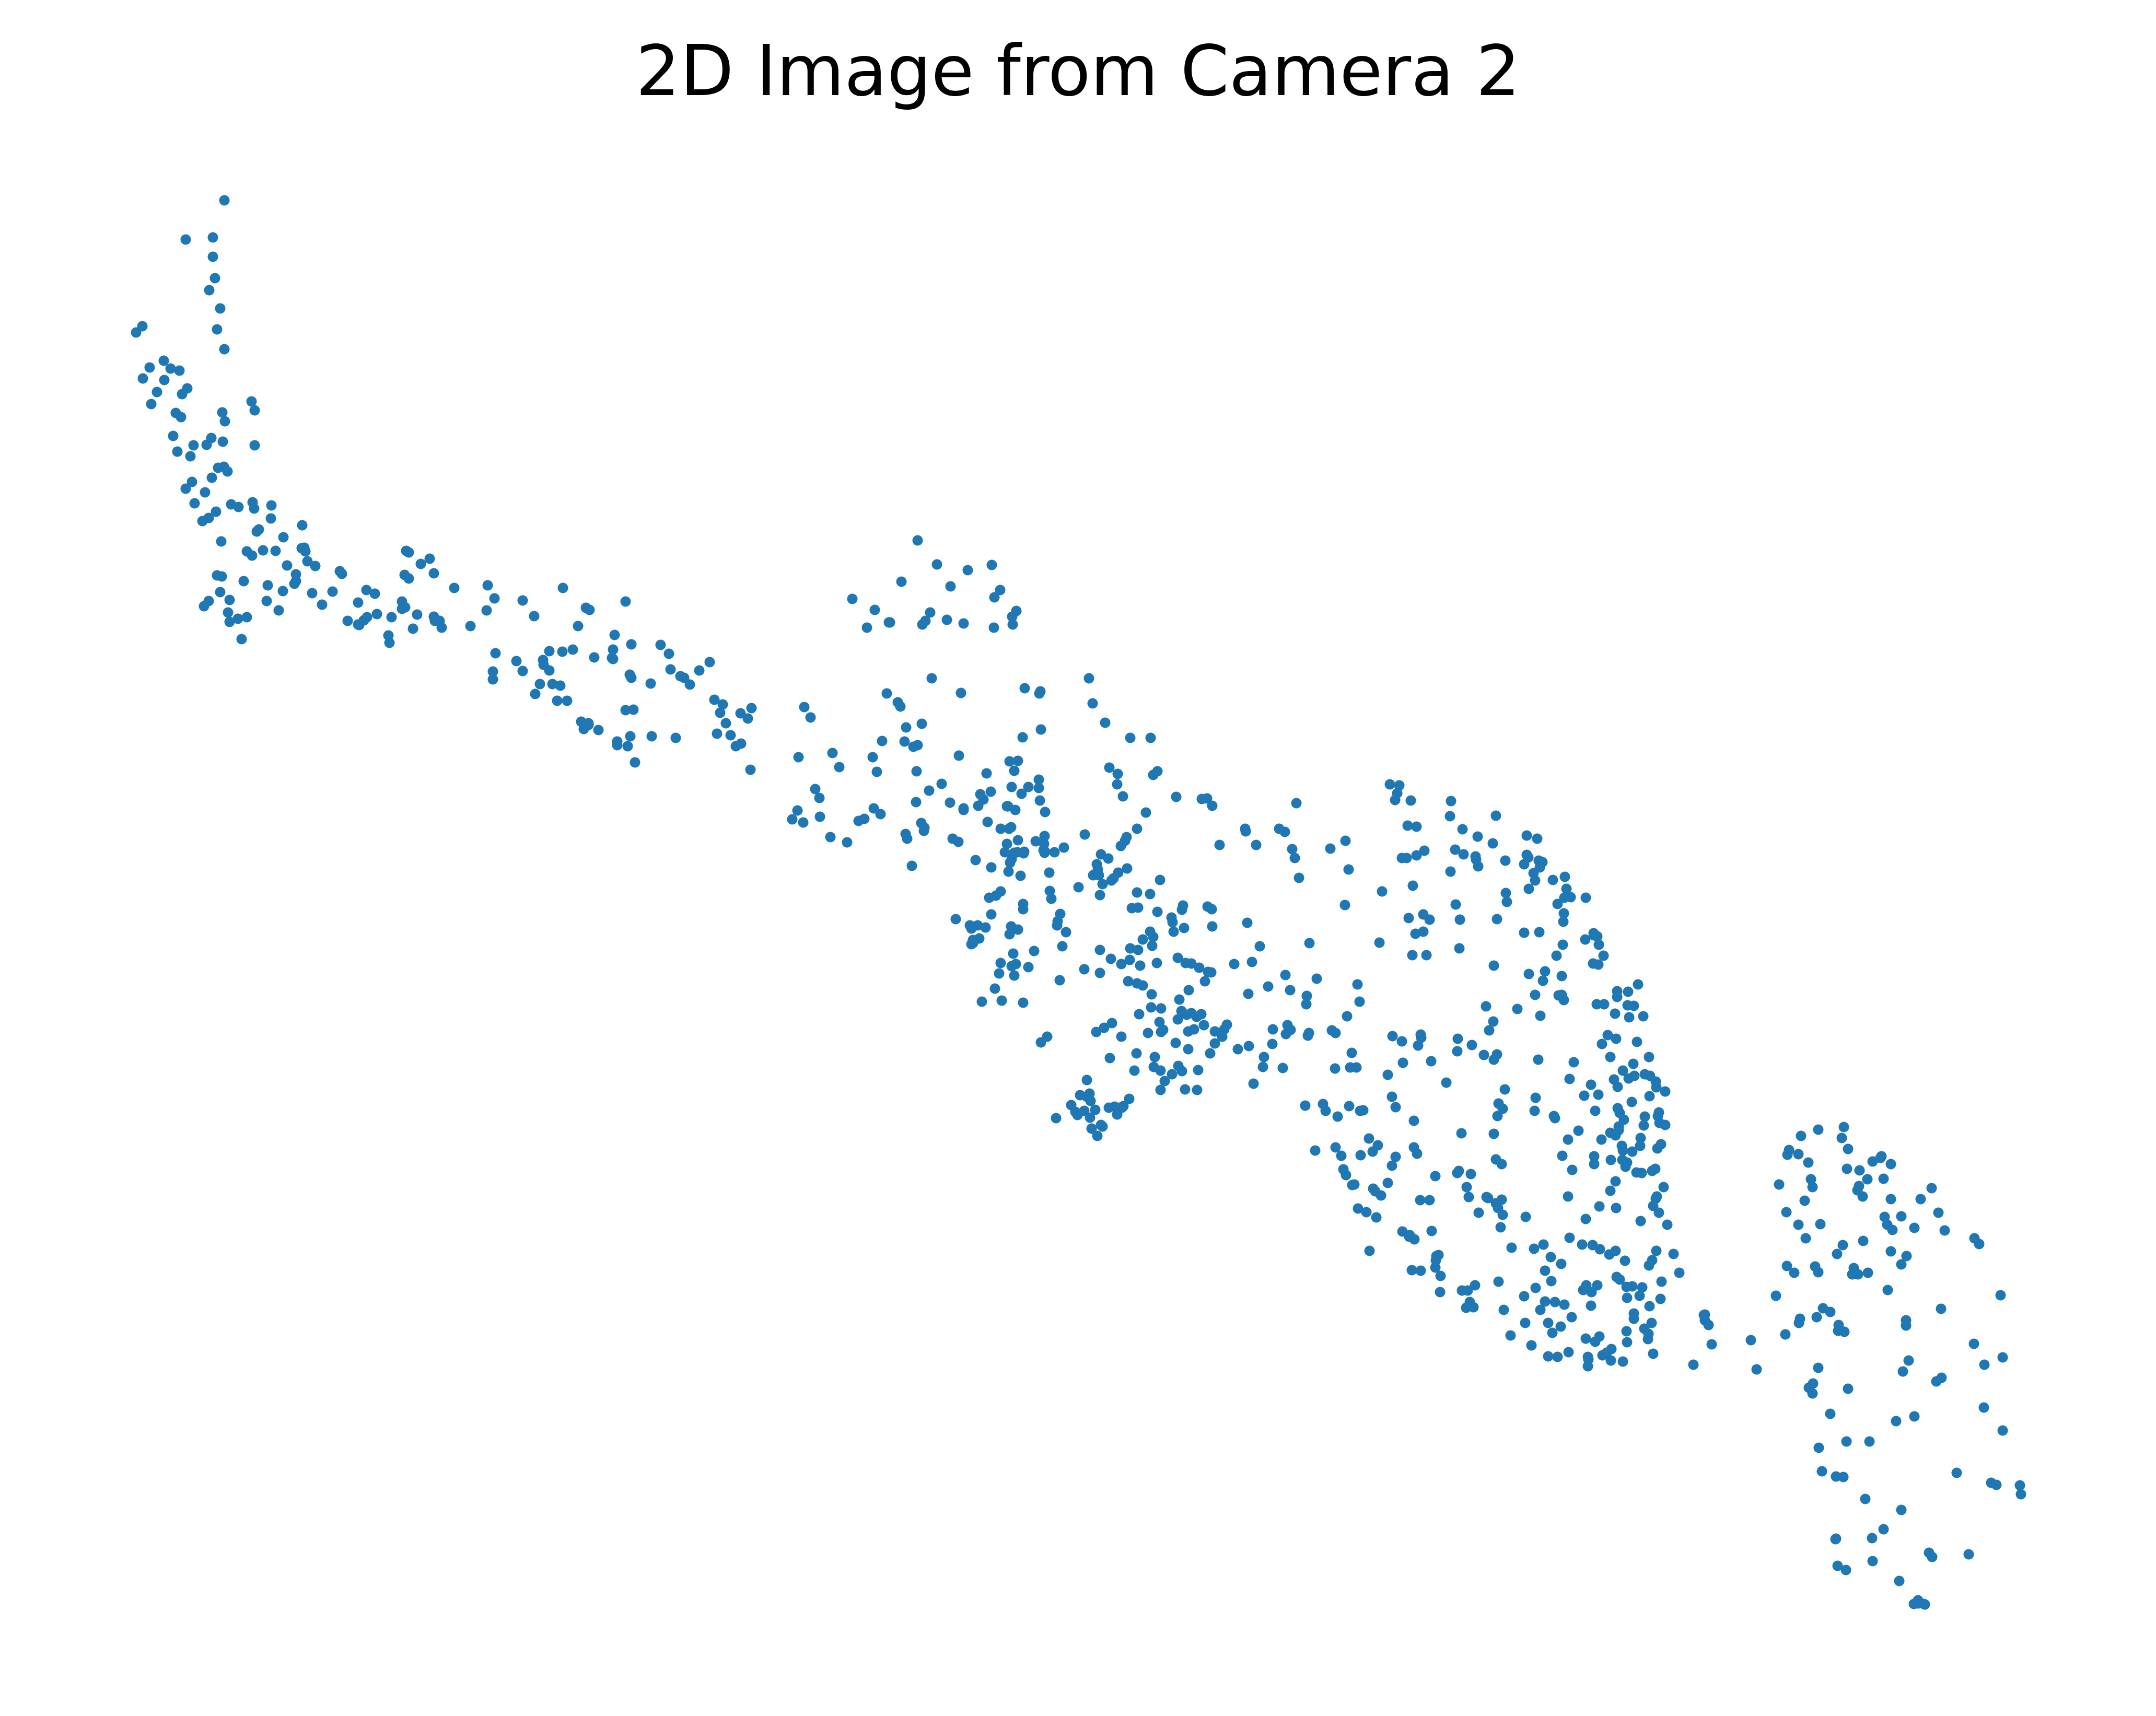

Parameters of Camera 3: 
Rotation along X: 0.0 degrees
Rotation along Y: 135.0 degrees
Rotation along Z: 0.0 degrees
Translation along X: 7071.422918957492
Translation along Y: 0
Translation along Z: -7071.422918957492


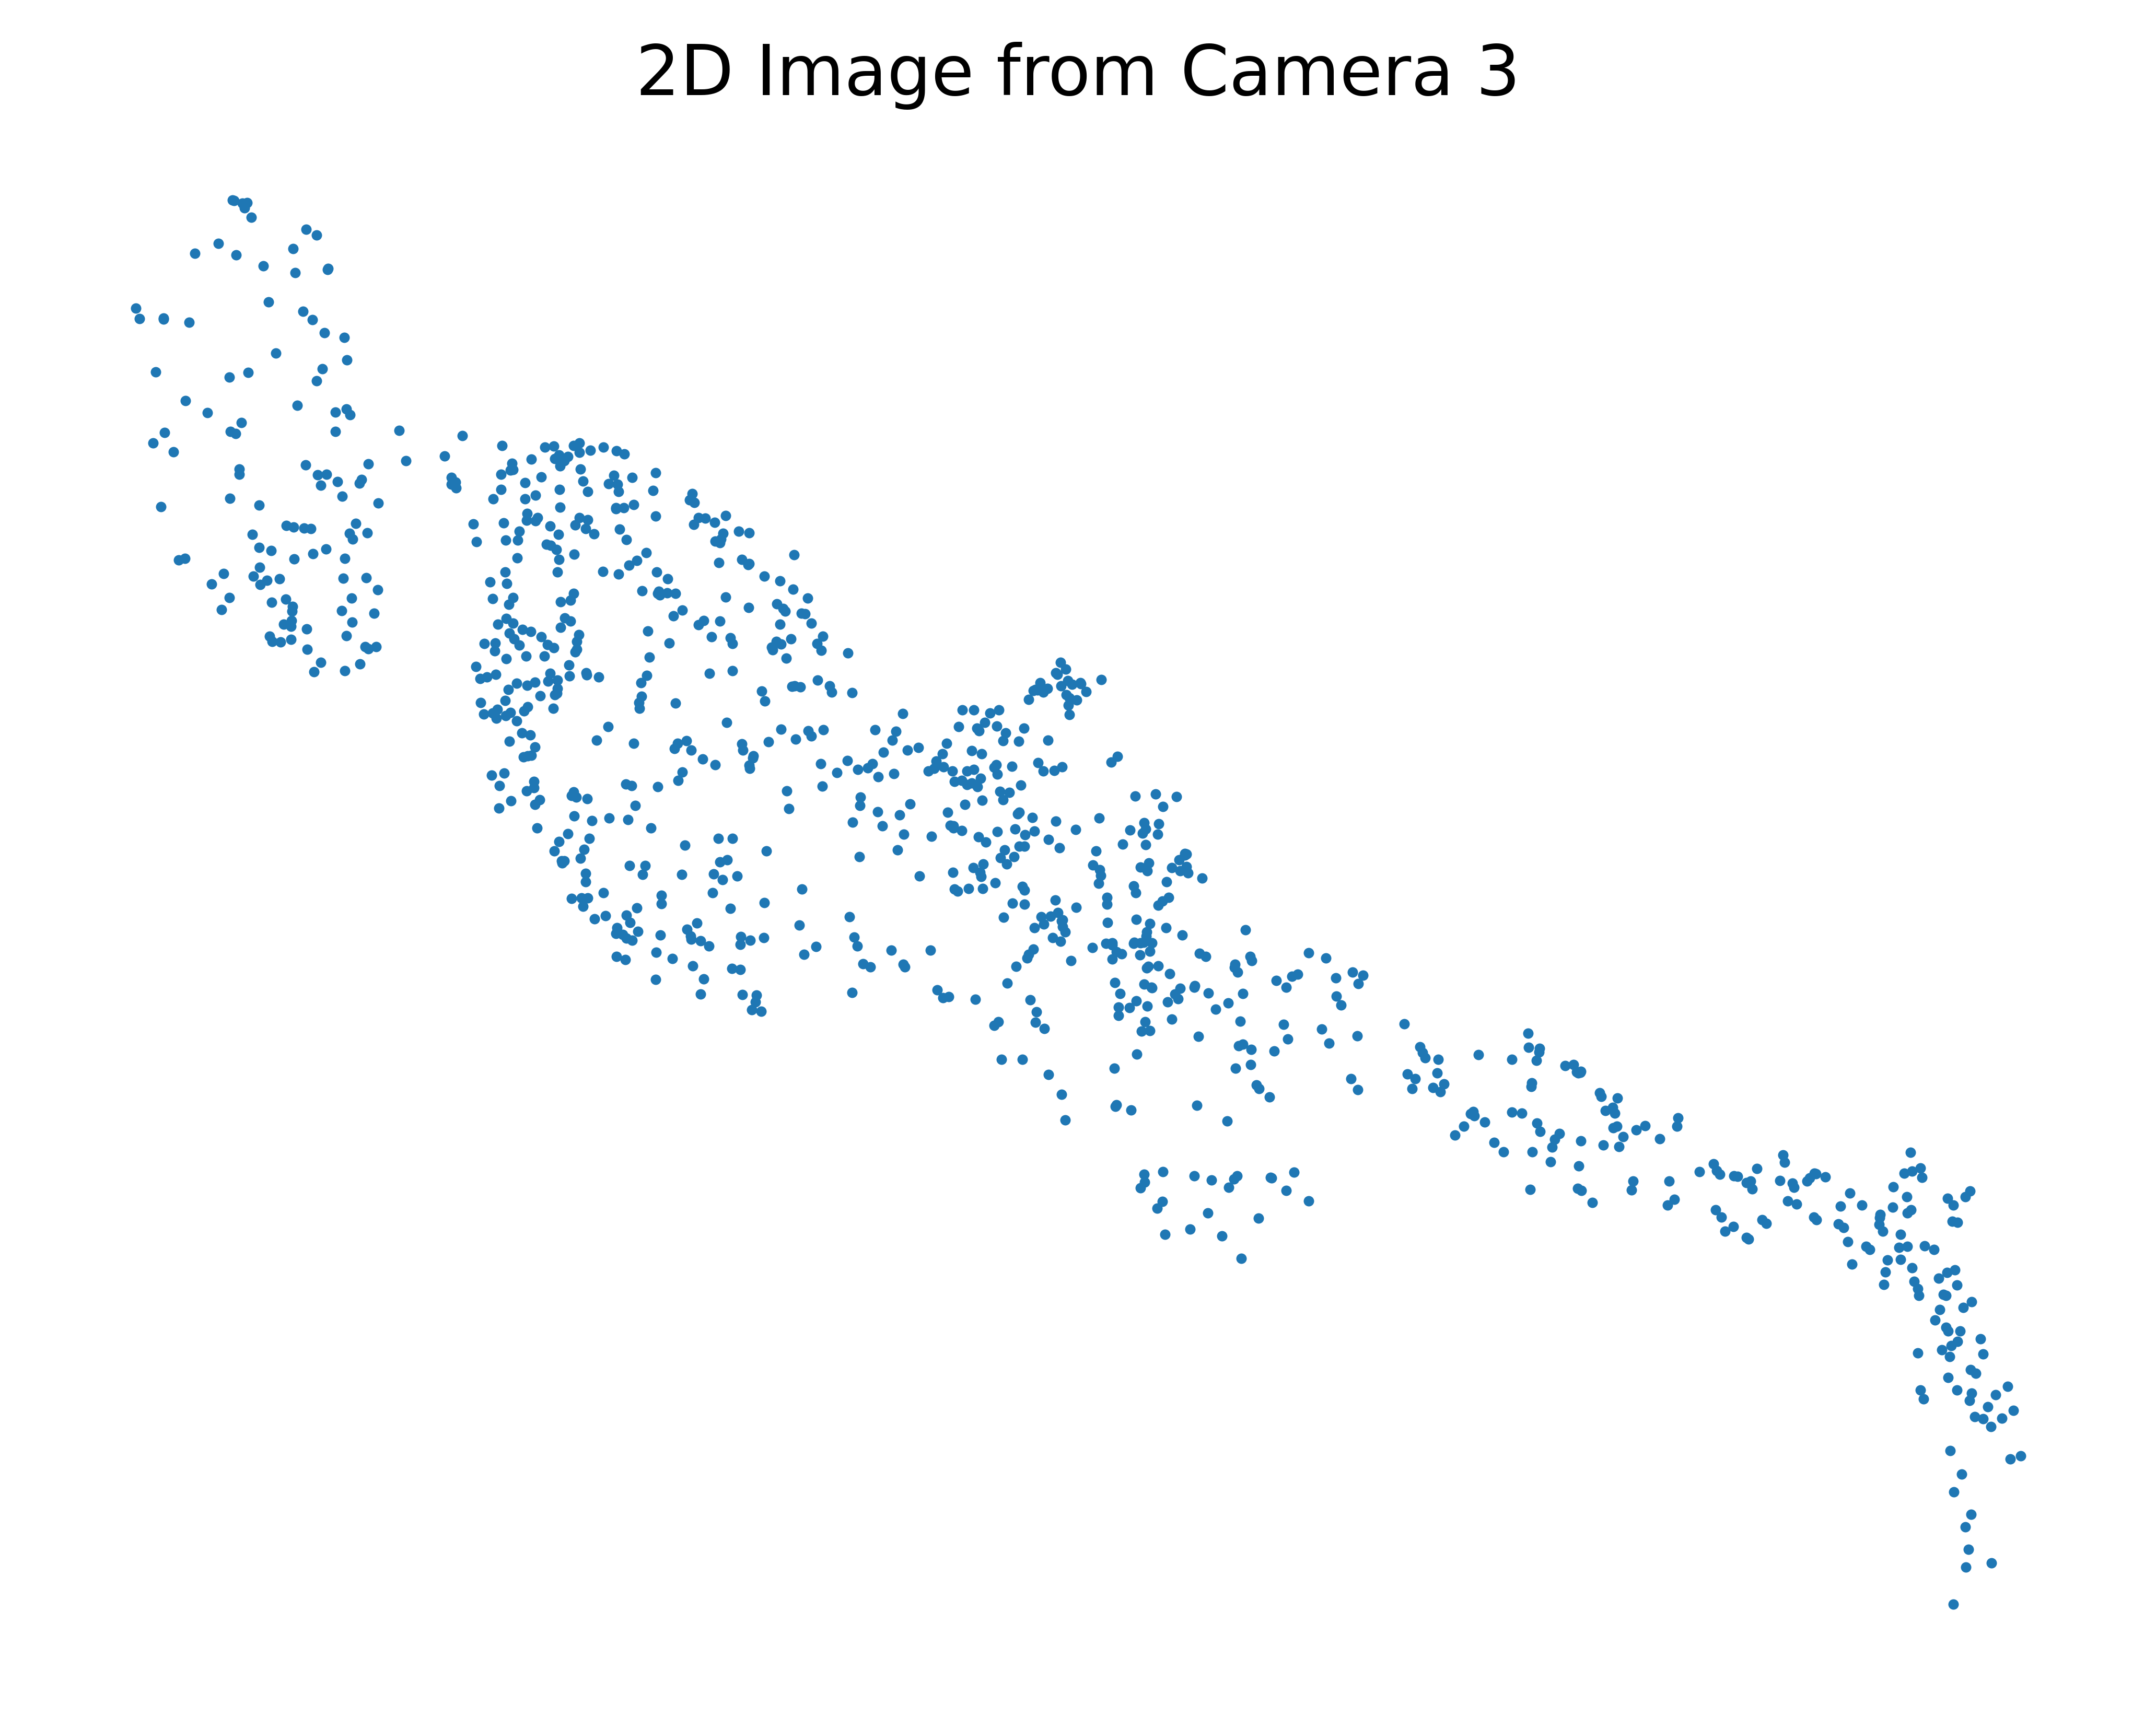

Parameters of Camera 4: 
Rotation along X: 0.0 degrees
Rotation along Y: 180.0 degrees
Rotation along Z: 0.0 degrees
Translation along X: 0
Translation along Y: 0
Translation along Z: -10000.502197265625


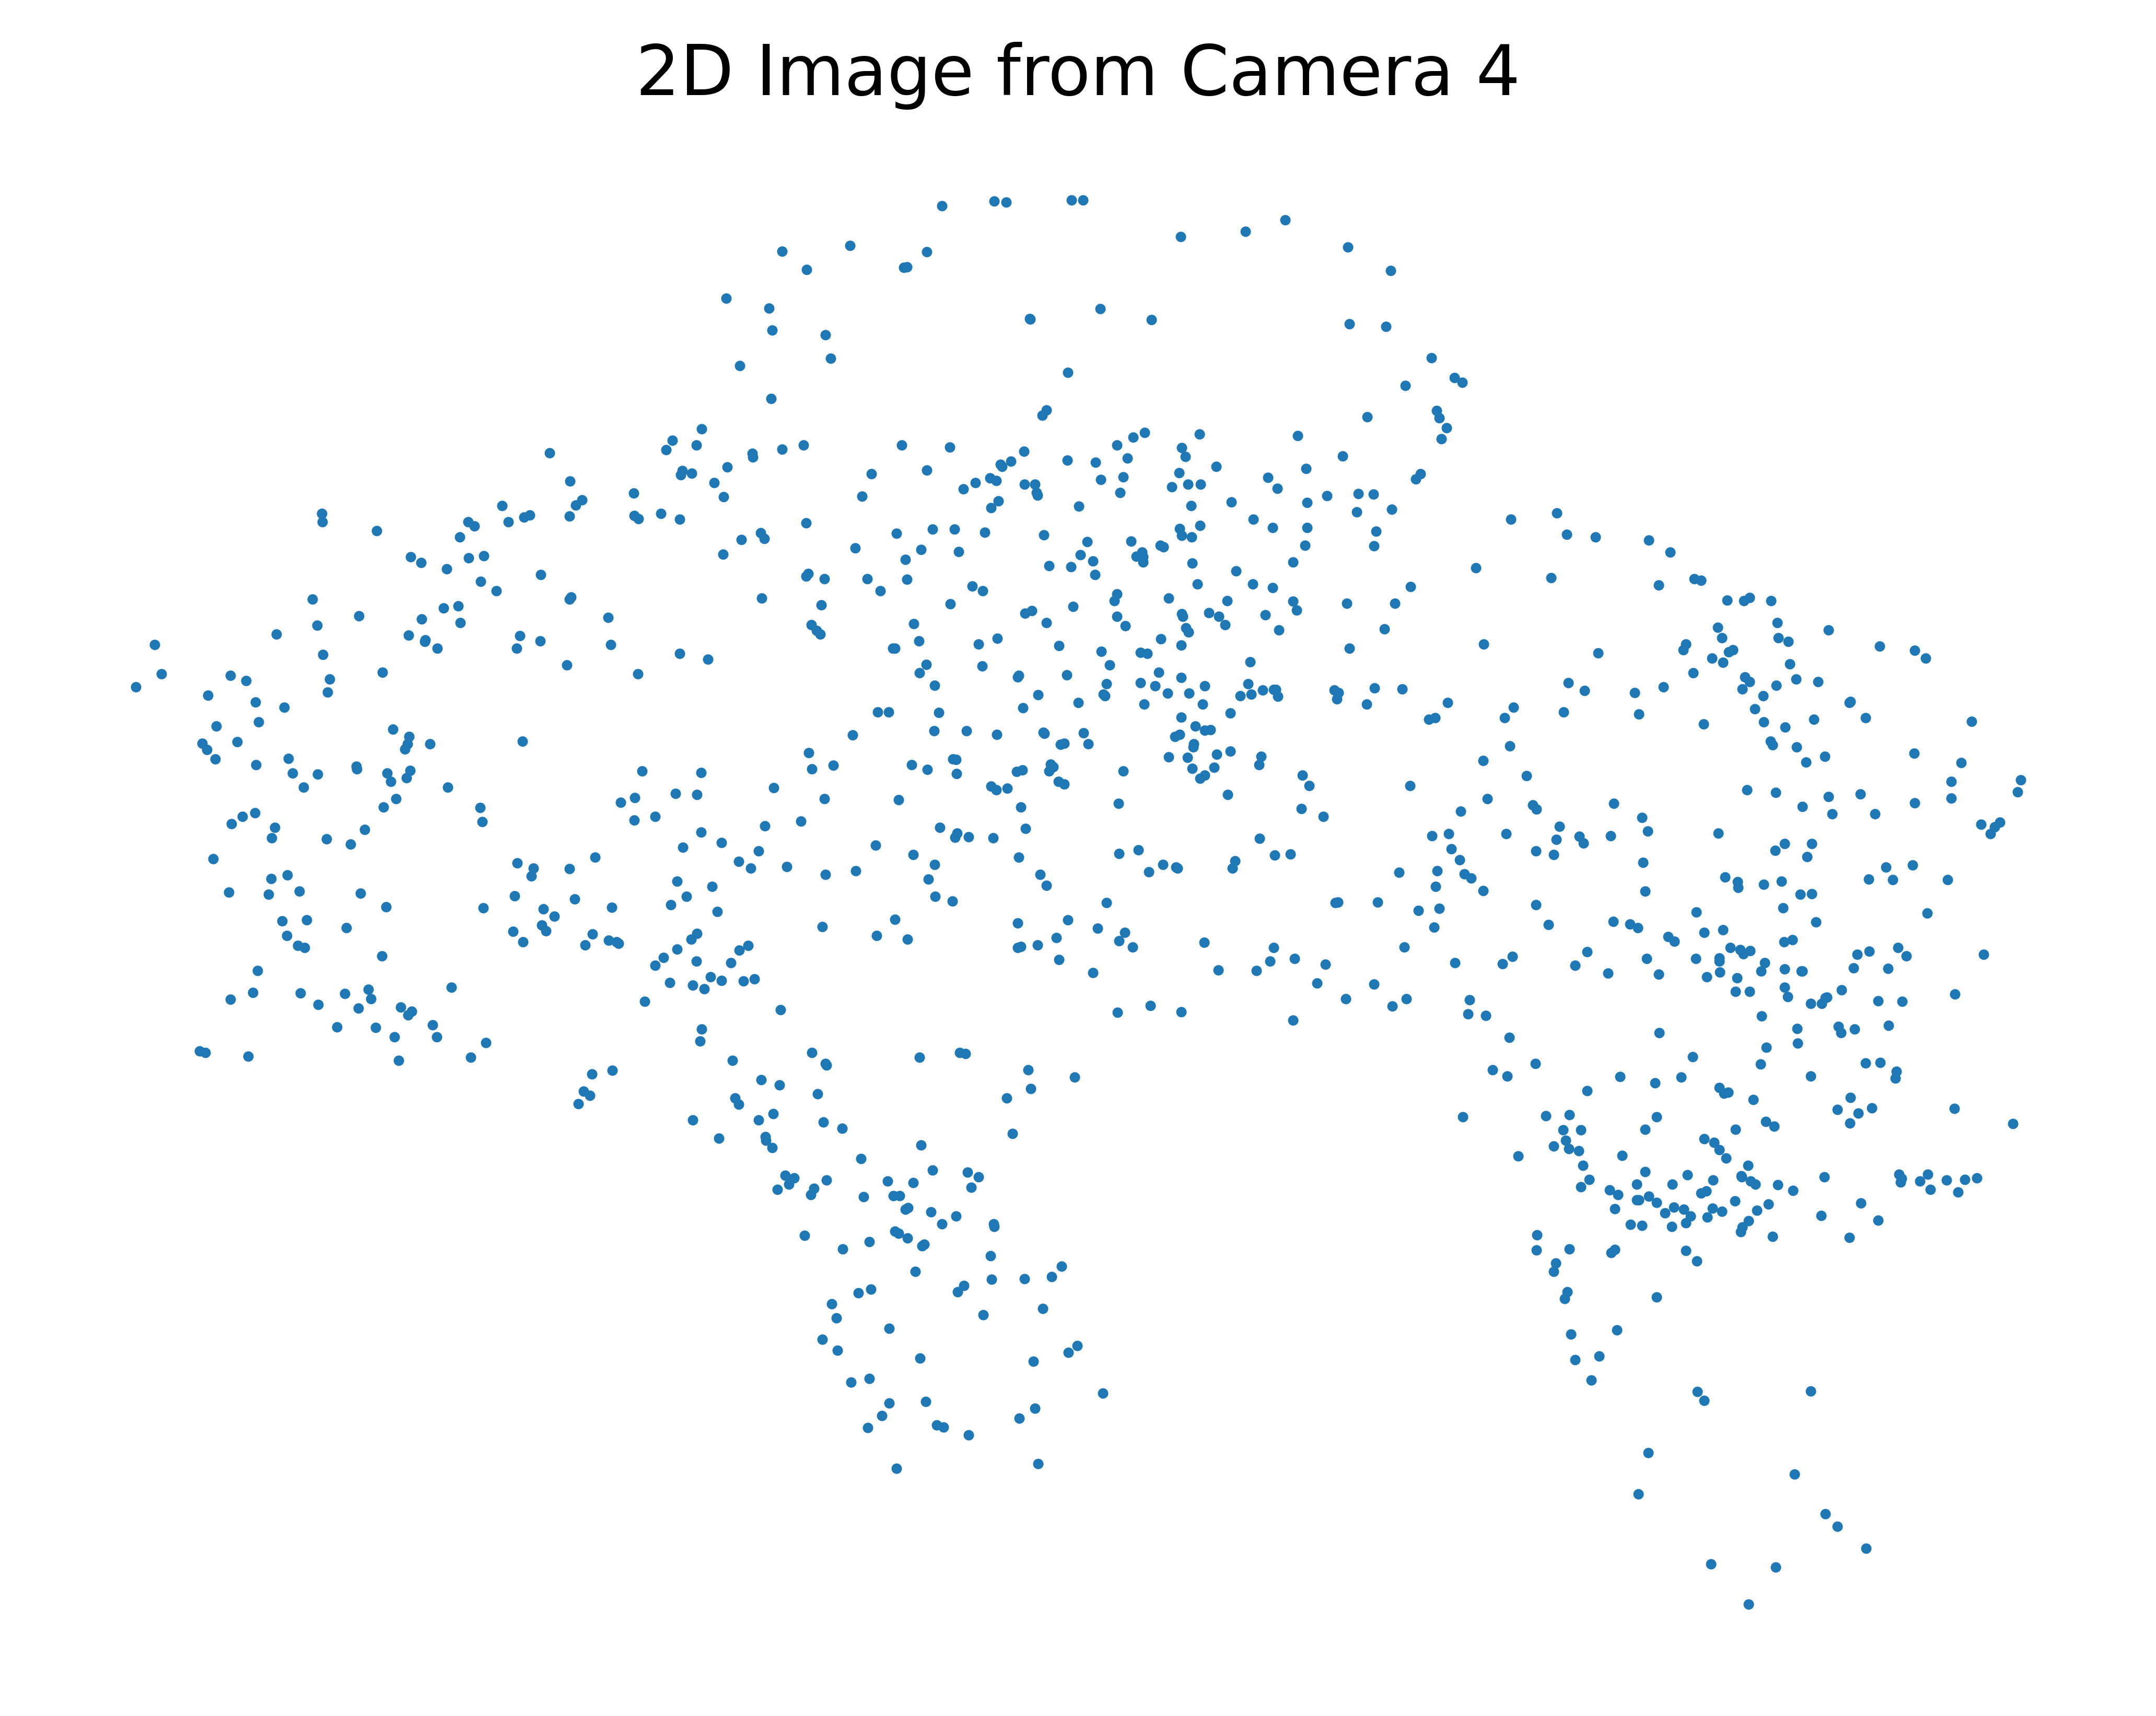

Parameters of Camera 5: 
Rotation along X: 0.0 degrees
Rotation along Y: 225.0 degrees
Rotation along Z: 0.0 degrees
Translation along X: -7071.422918957492
Translation along Y: 0
Translation along Z: -7071.422918957492


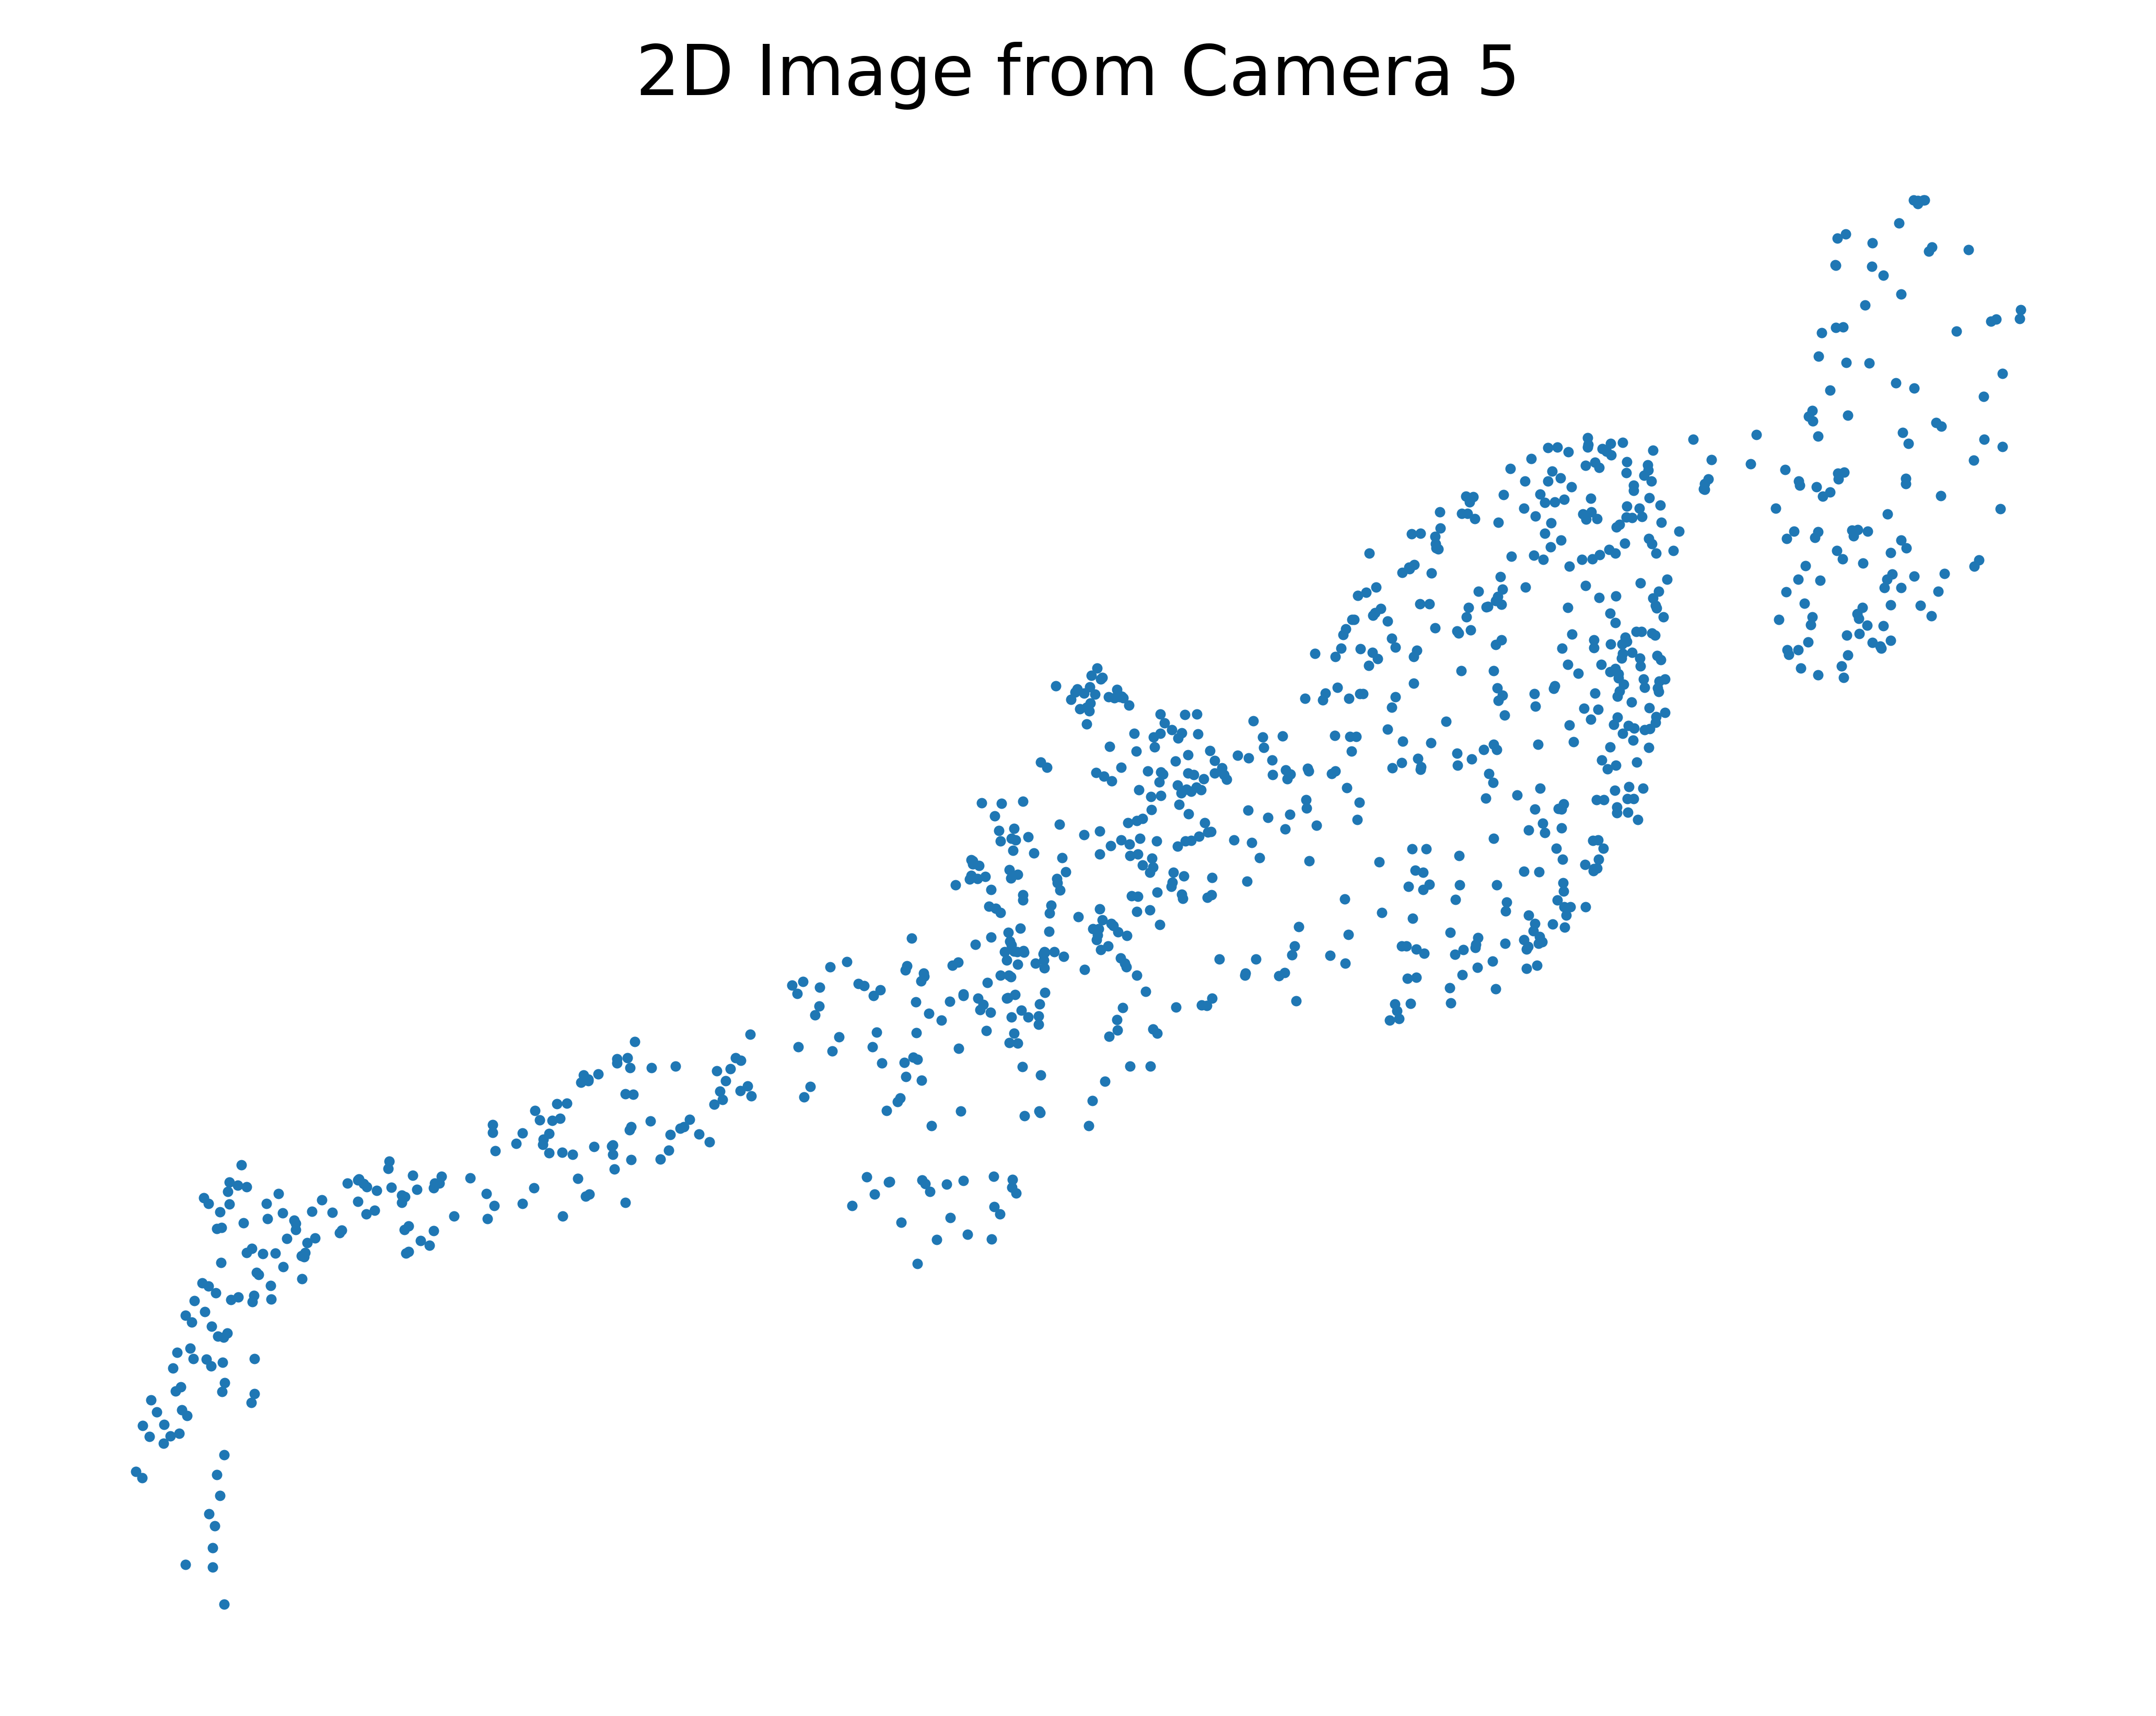

Parameters of Camera 6: 
Rotation along X: 0.0 degrees
Rotation along Y: 315.0 degrees
Rotation along Z: 0.0 degrees
Translation along X: -7071.422918957492
Translation along Y: 0
Translation along Z: 7071.422918957492


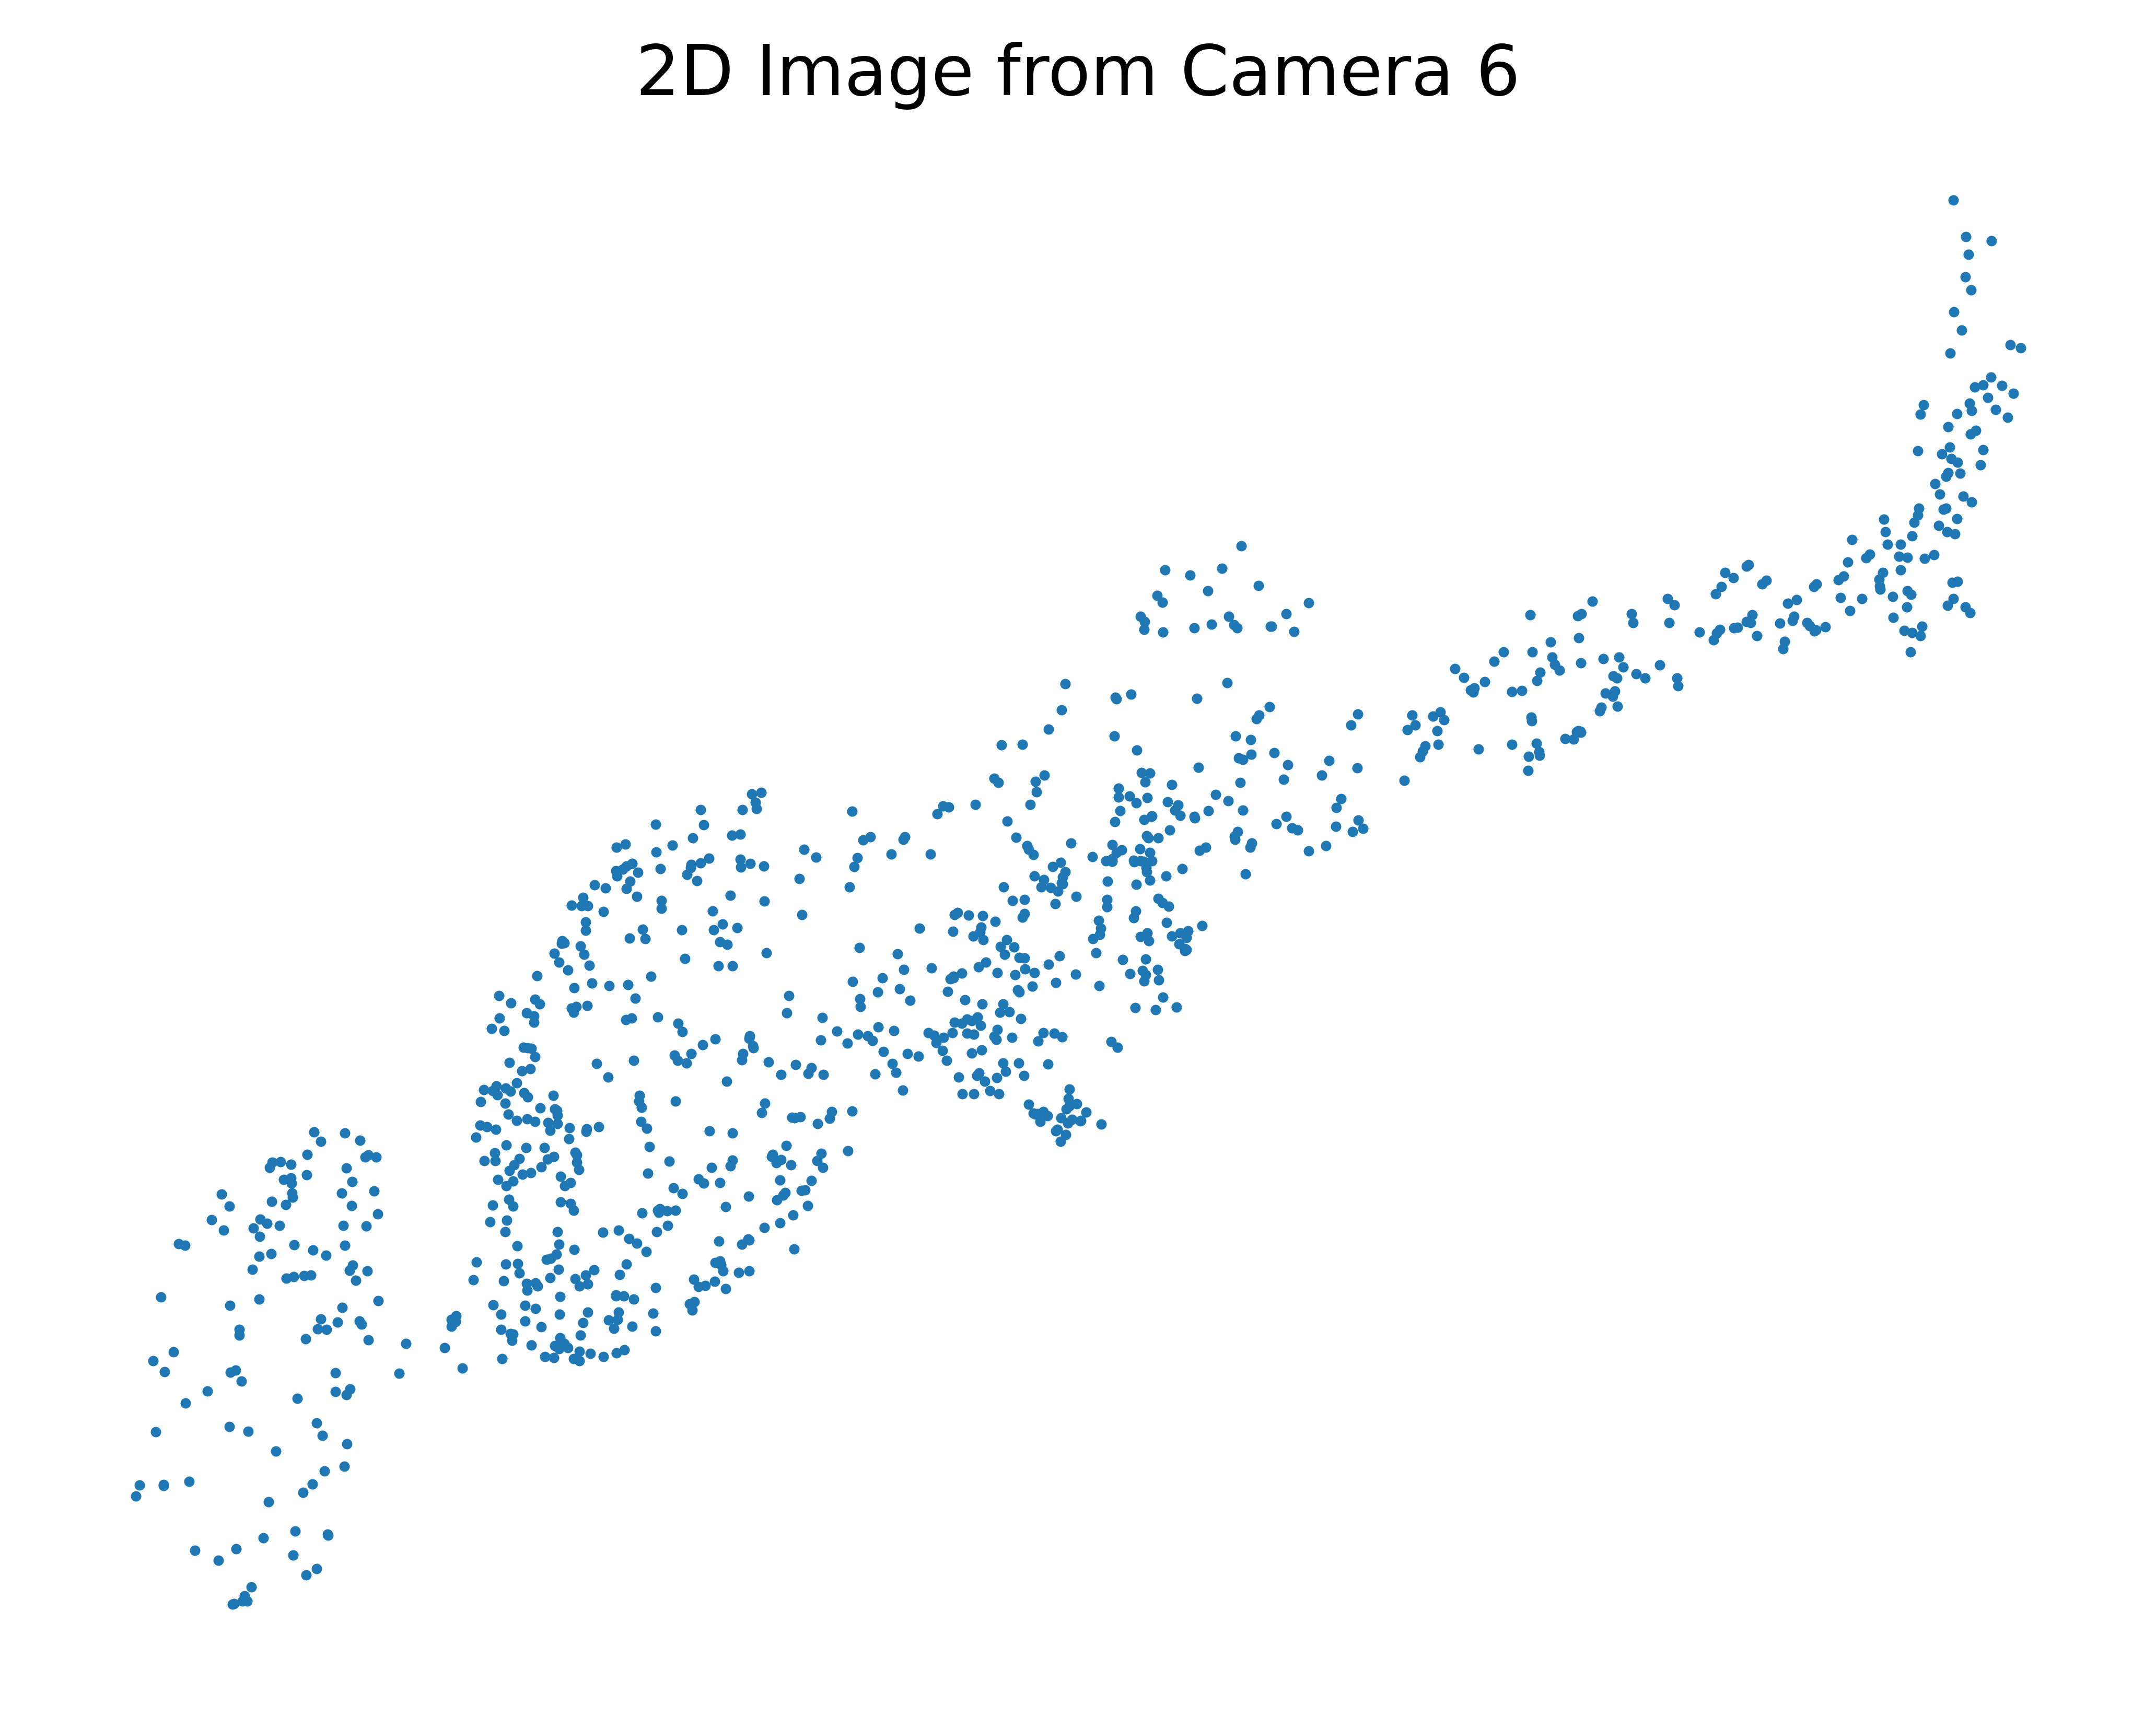

In [16]:
for camera_index in range(num_cameras):
    x_pos_arr = []
    y_pos_arr = []
    
    for point_index, point_info in p_array_2d_dict[camera_index]["Data"].items():
        x_pos_arr.append(point_info["2D"][0][0])
        y_pos_arr.append(point_info["2D"][1][0])
    
    
    print("Parameters of Camera "+str(p_array_2d_dict[camera_index]["Camera ID"])+": ")
    print("Rotation along X: {} degrees".format((-camera_dict[camera_index]["Camera Obj"].rot_x)*(180/(pi))))
    print("Rotation along Y: {} degrees".format((-camera_dict[camera_index]["Camera Obj"].rot_y)*(180/(pi))))
    print("Rotation along Z: {} degrees".format((-camera_dict[camera_index]["Camera Obj"].rot_z)*(180/(pi))))
    print("Translation along X: {}".format(-camera_dict[camera_index]["Camera Obj"].translate_x))
    print("Translation along Y: {}".format(-camera_dict[camera_index]["Camera Obj"].translate_y))
    print("Translation along Z: {}".format(-camera_dict[camera_index]["Camera Obj"].translate_z))
    
    
    plt.figure(dpi=800)
    plt.plot(x_pos_arr, y_pos_arr, ".", markersize=1.6)
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.title("2D Image from Camera "+str(p_array_2d_dict[camera_index]["Camera ID"]))
    plt.axis("off")
    plt.show()

# Implementing Matching Algorithms

Get homography estimate using SIFT

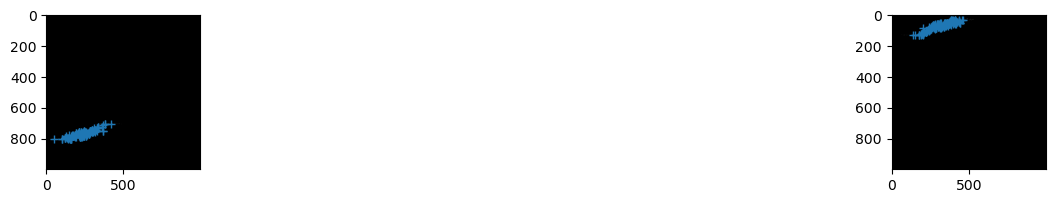

In [17]:
keypoints_1, keypoints_2, matches_12 = get_matches_using_sift('Camera_Snapshots/Camera_2.png', 'Camera_Snapshots/Camera_3.png')

Get the homography estimate on SIFT matched keypoints

In [18]:
grid_offset_1 = p_array_2d_dict[1]['Picture_Params']['Grid_Offset']
grid_spacing_1 = p_array_2d_dict[1]['Picture_Params']['Grid_Spacing']

grid_offset_2 = p_array_2d_dict[2]['Picture_Params']['Grid_Offset']
grid_spacing_2 = p_array_2d_dict[2]['Picture_Params']['Grid_Spacing']

homography_estimate_matrix = get_homography_estimate(keypoints_1, keypoints_2, matches_12, 
                                                          grid_spacing_1, grid_spacing_2, grid_offset_1, grid_offset_2)

print(homography_estimate_matrix)

[[-0.42212329 -0.29252667  2.17850635]
 [-0.0314976  -0.52657225  0.41279841]
 [-0.10429346 -0.51443525  1.        ]]


In [19]:
robust_homography_estimate_matrix, inliers = robust_homography_using_ransac(keypoints_1, keypoints_2, matches_12, 
                                                          grid_spacing_1, grid_spacing_2, grid_offset_1, grid_offset_2)

In [20]:
robust_homography_estimate_matrix

<ProjectiveTransform(matrix=
    [[-1.3586824 , -1.90323576,  4.86559145],
     [-0.04039452, -0.97003593,  0.55210524],
     [-0.12364123, -0.45405463,  1.        ]]) at 0x13f1069f610>

Verify that Homography calculation is indeed working using actual matched data

In [21]:
camera_1_pixel_map = []
for point_idx, point_info in p_array_2d_dict[1]['Data'].items():
    camera_1_pixel_map.append(point_info['2D_Image'])
camera_1_pixel_map = np.array(camera_1_pixel_map)

camera_2_pixel_map = []
for point_idx, point_info in p_array_2d_dict[2]['Data'].items():
    camera_2_pixel_map.append(point_info['2D_Image'])
camera_2_pixel_map = np.array(camera_2_pixel_map)

match_info = []
for i in range(num_points):
    match_info.append([i, i])
match_info = np.array(match_info)

camera_1_point_coordinate = np.array(get_2D_coordinate_from_camera_pixel(camera_1_pixel_map[0], grid_spacing_1, grid_offset_1))
camera_2_point_coordinate = np.array(get_2D_coordinate_from_camera_pixel(camera_2_pixel_map[750], grid_spacing_2, grid_offset_2))

camera_1_point_coordinate = np.reshape(camera_1_point_coordinate, (camera_1_point_coordinate.shape[0], 1))
camera_2_point_coordinate = np.reshape(camera_2_point_coordinate, (camera_2_point_coordinate.shape[0], 1))

camera_1_point_coordinate = get_homogeneous_representation(True, camera_1_point_coordinate)
camera_2_point_coordinate = get_homogeneous_representation(True, camera_2_point_coordinate)


homography_actual_matrix = get_homography_estimate(camera_1_pixel_map, camera_2_pixel_map, match_info, 
                                                        grid_spacing_1, grid_spacing_2, grid_offset_1, grid_offset_2)

Use the homography estimate matrix or the actual homographic matrix to compare the performance

In [22]:
print('Actual point:')
print(camera_1_point_coordinate)

camera_1_point_coordinate_evaluated = np.matmul(robust_homography_estimate_matrix, camera_2_point_coordinate)
camera_1_point_coordinate_evaluated = camera_1_point_coordinate_evaluated/camera_1_point_coordinate_evaluated[-1]

print('Point obtained by homographic transformation')
print(camera_1_point_coordinate_evaluated)

Actual point:
[[4.266  ]
 [0.33464]
 [1.     ]]
Point obtained by homographic transformation
[[4.52941653]
 [0.29251401]
 [1.        ]]


## Run Projective ICP on the image pixels. 
Take the image pixels from the 2D Dictionary, as the matching is already done, to get the comparison with the actual result.

In [23]:
camera_1_pixel_map

array([[711, 374],
       [781, 157],
       [751, 272],
       ...,
       [743, 279],
       [786, 175],
       [731, 304]])

In [24]:
# Get the array of points for the two images

camera_1_coordinate_array = []
camera_2_coordinate_array = []
for point_idx in range(num_points):
    camera_1_pt_coordinate = np.array(get_2D_coordinate_from_camera_pixel(camera_1_pixel_map[point_idx], grid_spacing_1, grid_offset_1))
    camera_2_pt_coordinate = np.array(get_2D_coordinate_from_camera_pixel(camera_2_pixel_map[point_idx], grid_spacing_2, grid_offset_2))

    camera_1_pt_coordinate = np.reshape(camera_1_pt_coordinate, (camera_1_pt_coordinate.shape[0], 1))
    camera_2_pt_coordinate = np.reshape(camera_2_pt_coordinate, (camera_2_pt_coordinate.shape[0], 1))

    camera_1_pt_coordinate = get_homogeneous_representation(True, camera_1_pt_coordinate)
    camera_2_pt_coordinate = get_homogeneous_representation(True, camera_2_pt_coordinate)

    camera_1_coordinate_array.append(camera_1_pt_coordinate.T.tolist()[0])
    camera_2_coordinate_array.append(camera_2_pt_coordinate.T.tolist()[0])

camera_1_coordinate_array = np.array(camera_1_coordinate_array)
camera_2_coordinate_array = np.array(camera_2_coordinate_array)

refined_homography, projective_correspondence_array, mean_error = projective_icp(camera_2_coordinate_array.T, 
                                                                                 camera_1_coordinate_array.T, 
                                                                                 robust_homography_estimate_matrix, max_iterations=50)

Iteration - 0
Mean error in iteration - 0.0001954778260771783
Iteration - 1
Mean error in iteration - 0.0001767567360743182
Iteration - 2
Mean error in iteration - 0.0001668929802859994
Iteration - 3
Mean error in iteration - 0.00015988064236948824
Iteration - 4
Mean error in iteration - 0.00015084273184283792
Iteration - 5
Mean error in iteration - 0.00014617236387002287
Iteration - 6
Mean error in iteration - 0.00014571267203068145


In [25]:
mean_error

0.00014617236387002287

In [26]:
refined_homography

array([[-1.1091019 , -1.02900415,  4.94454951],
       [-0.01319479, -0.978905  ,  0.57223615],
       [-0.0457785 , -0.23809627,  1.        ]])

Validate if refined homography is working

In [27]:
projective_correspondence_array

[[0, 326],
 [1, 464],
 [2, 2],
 [3, 3],
 [4, 310],
 [5, 5],
 [6, 440],
 [7, 7],
 [8, 375],
 [9, 9],
 [10, 276],
 [11, 11],
 [12, 291],
 [13, 13],
 [14, 190],
 [15, 66],
 [16, 16],
 [17, 974],
 [18, 18],
 [19, 19],
 [20, 92],
 [21, 598],
 [22, 877],
 [23, 23],
 [24, 24],
 [25, 25],
 [26, 26],
 [27, 316],
 [28, 28],
 [29, 432],
 [30, 30],
 [31, 31],
 [32, 114],
 [33, 33],
 [34, 527],
 [35, 35],
 [36, 209],
 [37, 37],
 [38, 38],
 [39, 39],
 [40, 40],
 [41, 41],
 [42, 475],
 [43, 43],
 [44, 44],
 [45, 45],
 [46, 46],
 [47, 429],
 [48, 48],
 [49, 142],
 [50, 50],
 [51, 933],
 [52, 52],
 [53, 53],
 [54, 54],
 [55, 55],
 [56, 304],
 [57, 111],
 [58, 953],
 [59, 59],
 [60, 60],
 [61, 61],
 [62, 62],
 [63, 991],
 [64, 64],
 [65, 653],
 [66, 148],
 [67, 67],
 [68, 412],
 [69, 69],
 [70, 70],
 [71, 71],
 [72, 807],
 [73, 73],
 [74, 538],
 [75, 75],
 [76, 206],
 [77, 77],
 [78, 78],
 [79, 933],
 [80, 476],
 [81, 923],
 [82, 466],
 [83, 83],
 [84, 84],
 [85, 138],
 [86, 86],
 [87, 462],
 [88, 754],

In [28]:
index_1 = projective_correspondence_array[0][0]
index_2 = projective_correspondence_array[0][1]

In [29]:
camera_1_coordinate_array[index_1]

array([4.266  , 0.33464, 1.     ])

In [30]:
camera_2_coordinate_array[index_2]

array([0.738  , 0.26552, 1.     ])

In [31]:
camera_1_evaluated_pt = np.matmul(refined_homography, camera_2_coordinate_array[index_2])
camera_1_evaluated_pt = camera_1_evaluated_pt/camera_1_evaluated_pt[-1]
camera_1_evaluated_pt

array([4.26669721, 0.33508397, 1.        ])

With initial robust estimate

In [32]:
camera_1_evaluated_pt = np.matmul(robust_homography_estimate_matrix, camera_2_coordinate_array[index_2])
camera_1_evaluated_pt = camera_1_evaluated_pt/camera_1_evaluated_pt[-1]
camera_1_evaluated_pt

array([4.25979444, 0.33587005, 1.        ])

Compare the accuracy of Robust Homography Estimate using RANSAC and the Refined Homography Estimate using Projective ICP

In [33]:
err_array_ransac = []
err_array_picp = []
for correspondence in projective_correspondence_array:
    correspondence[0]
    index_1 = correspondence[0]
    index_2 = correspondence[1]

    camera_1_actual_pt = camera_1_coordinate_array[index_1].reshape(3, 1)
    camera_1_evaluated_pt = np.matmul(robust_homography_estimate_matrix, camera_2_coordinate_array[index_2]).reshape(3, 1)
    camera_1_evaluated_pt = camera_1_evaluated_pt/camera_1_evaluated_pt[-1]

    camera_1_evaluated_pt_picp = np.matmul(refined_homography, camera_2_coordinate_array[index_2]).reshape(3, 1)
    camera_1_evaluated_pt_picp = camera_1_evaluated_pt_picp/camera_1_evaluated_pt_picp[-1]

    err_array_ransac.append(get_projective_distance_metric(camera_1_actual_pt.T, camera_1_evaluated_pt.T))
    err_array_picp.append(get_projective_distance_metric(camera_1_actual_pt.T, camera_1_evaluated_pt_picp.T))

print('Error obtained using Robust Homography - {}'.format(np.mean(err_array_ransac)))
print('Error obtained using Refined Homography - {}'.format(np.mean(err_array_picp)))

Error obtained using Robust Homography - 0.3146085161977282
Error obtained using Refined Homography - 0.3146497067156656


Order the coordinate array based on the correspondences

In [34]:
camera_1_coordinate_array_ordered = []
camera_2_coordinate_array_ordered = []

for correspondence in projective_correspondence_array:
    camera_1_coordinate_array_ordered.append(camera_1_coordinate_array[correspondence[0]])
    camera_2_coordinate_array_ordered.append(camera_2_coordinate_array[correspondence[1]])
camera_1_coordinate_array_ordered = np.array(camera_1_coordinate_array_ordered)
camera_2_coordinate_array_ordered = np.array(camera_2_coordinate_array_ordered)

In [35]:
image = np.zeros([num_grid_x, num_grid_y])
for point_idx in range(camera_2_coordinate_array_ordered.shape[0]):
    point_info = np.matmul(refined_homography, camera_2_coordinate_array_ordered[point_idx])
    point_info = point_info/point_info[-1]
    point_x_info = point_info[0]
    point_y_info = point_info[1]

    grid_spacing = p_array_2d_dict[2]['Picture_Params']['Grid_Spacing']
    grid_offset = p_array_2d_dict[2]['Picture_Params']['Grid_Offset']
    grid_size = p_array_2d_dict[2]['Picture_Params']['Num_Grids']

    pixel = get_camera_pixel_from_2D_coordinate([point_x_info, point_y_info], grid_spacing, grid_offset, grid_size)

    image[pixel[0]][pixel[1]] = 0xFF

data = Image.fromarray(image.astype('uint8'))
data.save('Camera_Snapshots/Camera_{}_reconstructed.png'.format(1+1))

Linear Reconstruction (using only 2 cameras)

API for linear reconstruction using Linear Eigen Method

In [36]:
def linear_eigen_method(x_camera1, y_camera1, x_camera2, y_camera2, M_camera1, M_camera2):

    A=np.array([(x_camera1)*M_camera1[2]-M_camera1[0], 
       (y_camera1)*M_camera1[2]-M_camera1[1], 
       (x_camera2)*M_camera2[2]-M_camera2[0], 
       (y_camera2)*M_camera2[2]-M_camera2[1]
      ])
    A_transpose_A = np.matmul(A.T, A)

    eigenvalues, eigenvectors = linalg.eig(A_transpose_A)

    optimal_P = eigenvectors.T[np.argmin(eigenvalues)].reshape(4, 1)
    scaling_factor = optimal_P[-1]
    optimal_P = optimal_P/optimal_P[-1]
    return optimal_P[0:-1], scaling_factor

In [37]:
cam_1_index = 1
cam_2_index = 2

M_camera_1 = camera_dict[cam_1_index]['Camera Matrix']
M_camera_2 = camera_dict[cam_2_index]['Camera Matrix']

With the matches obtained by Projective ICP

In [38]:
match_list = []
for correspondence in projective_correspondence_array:
    if correspondence[0] == correspondence[1]:
        match_list.append(correspondence)

In [39]:
len(match_list)

558

In [40]:
P_3D_array_reconstructed = []
outlier_pts = 0

for point_idx in range(camera_1_coordinate_array_ordered.shape[0]):
    optimal_P, scaling_factor = linear_eigen_method(camera_1_coordinate_array_ordered[point_idx][0], 
                                    camera_1_coordinate_array_ordered[point_idx][1], 
                                    camera_2_coordinate_array_ordered[point_idx][0], 
                                    camera_2_coordinate_array_ordered[point_idx][1], 
                                    M_camera_1, M_camera_2)

    P_3D_array_reconstructed.append(optimal_P.flatten())

P_3D_array_reconstructed = np.array(P_3D_array_reconstructed)

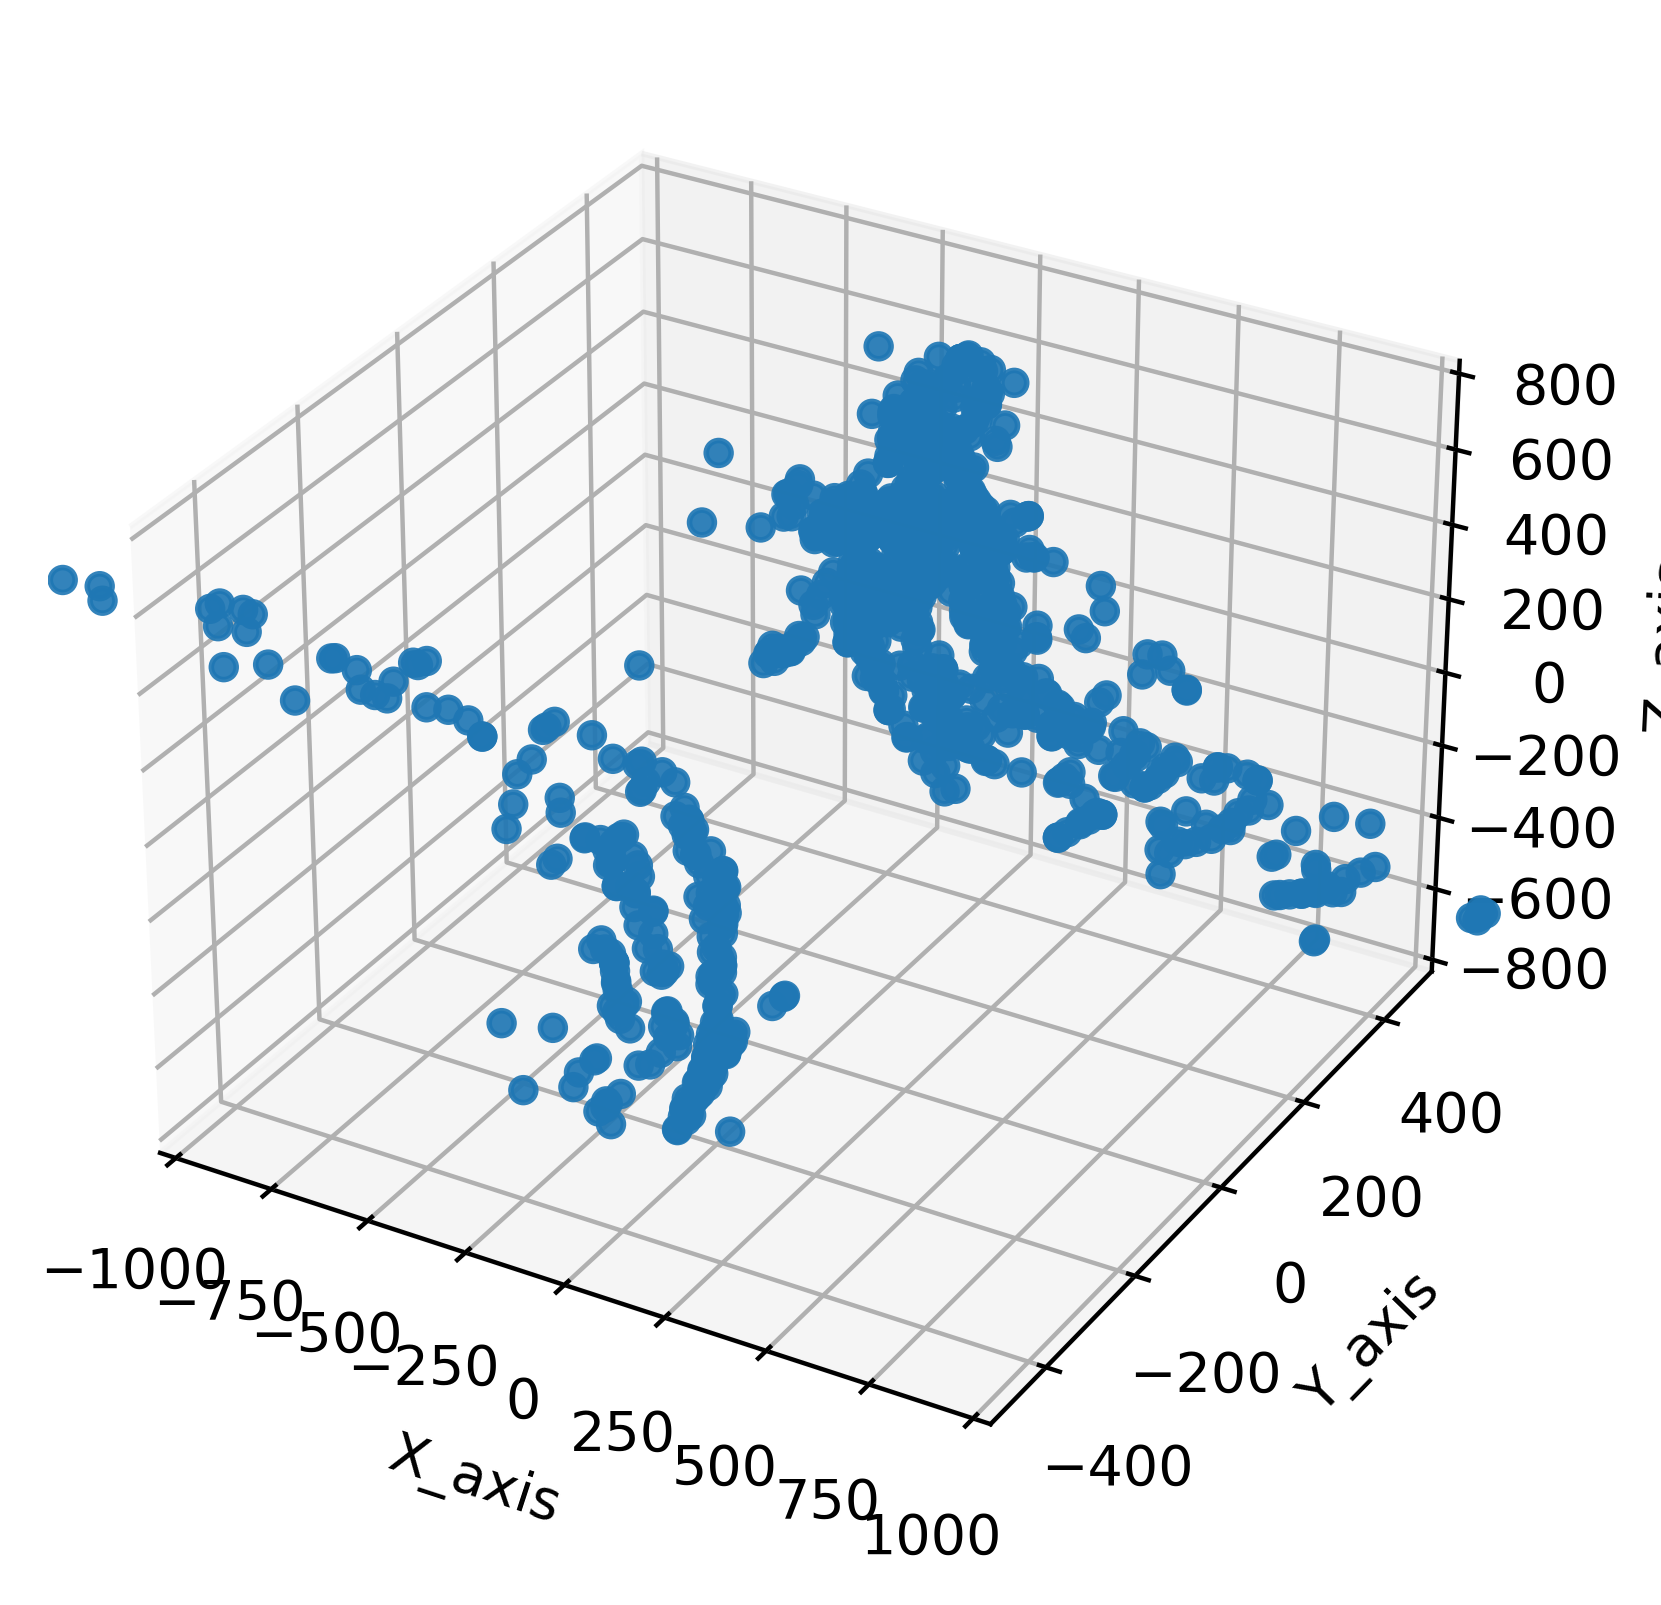

In [41]:
visualize_3D(P_3D_array_reconstructed)

With Matched Data

In [42]:
P_3D_array_reconstructed_matched = []
outlier_pts = 0

for point_idx in range(len(match_list)):
    optimal_P, scaling_factor = linear_eigen_method(camera_1_coordinate_array_ordered[match_list[point_idx][0]][0], 
                                    camera_1_coordinate_array_ordered[match_list[point_idx][0]][1], 
                                    camera_2_coordinate_array_ordered[match_list[point_idx][1]][0], 
                                    camera_2_coordinate_array_ordered[match_list[point_idx][1]][1], 
                                    M_camera_1, M_camera_2)

    P_3D_array_reconstructed_matched.append(optimal_P.flatten())

P_3D_array_reconstructed_matched = np.array(P_3D_array_reconstructed_matched)

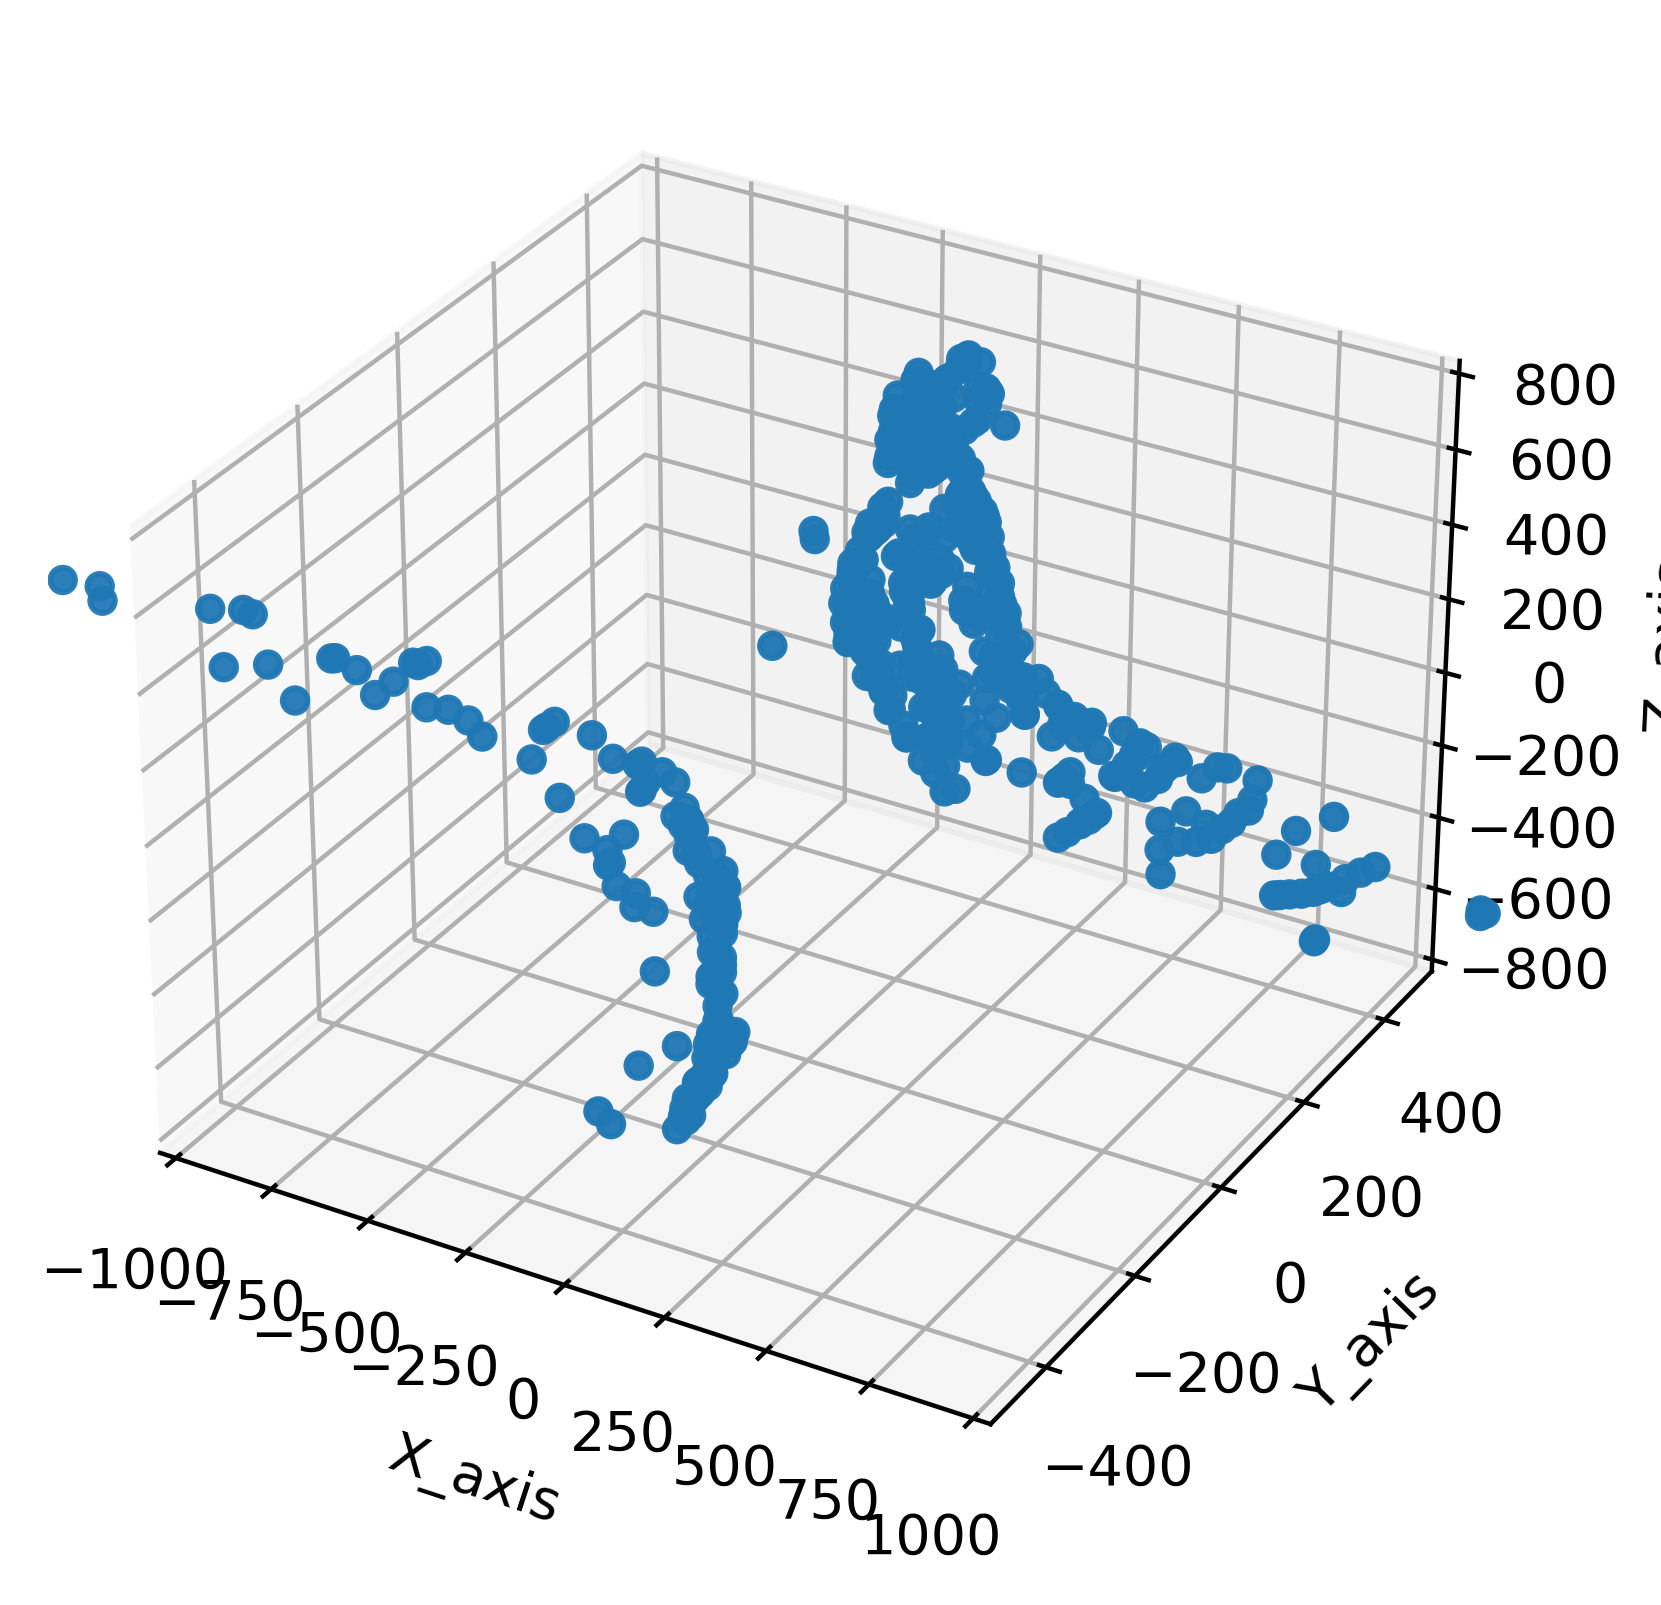

In [43]:
visualize_3D(P_3D_array_reconstructed_matched)

On actual Point Data (Instead of parsing the pixel arrays)

With Correspondences obtained via Projective ICP

In [44]:
P_3D_array_reconstructed_matched_1 = []
outlier_pts = 0

for correspondence in projective_correspondence_array:
    optimal_P, scaling_factor = linear_eigen_method(p_array_2d_dict[cam_1_index]['Data'][correspondence[0]]['2D'][0][0], 
                                    p_array_2d_dict[cam_1_index]['Data'][correspondence[0]]['2D'][1][0], 
                                    p_array_2d_dict[cam_2_index]['Data'][correspondence[1]]['2D'][0][0], 
                                    p_array_2d_dict[cam_2_index]['Data'][correspondence[1]]['2D'][1][0], 
                                    M_camera_1, M_camera_2)

    P_3D_array_reconstructed_matched_1.append(optimal_P.flatten())

P_3D_array_reconstructed_matched_1 = np.array(P_3D_array_reconstructed_matched_1)

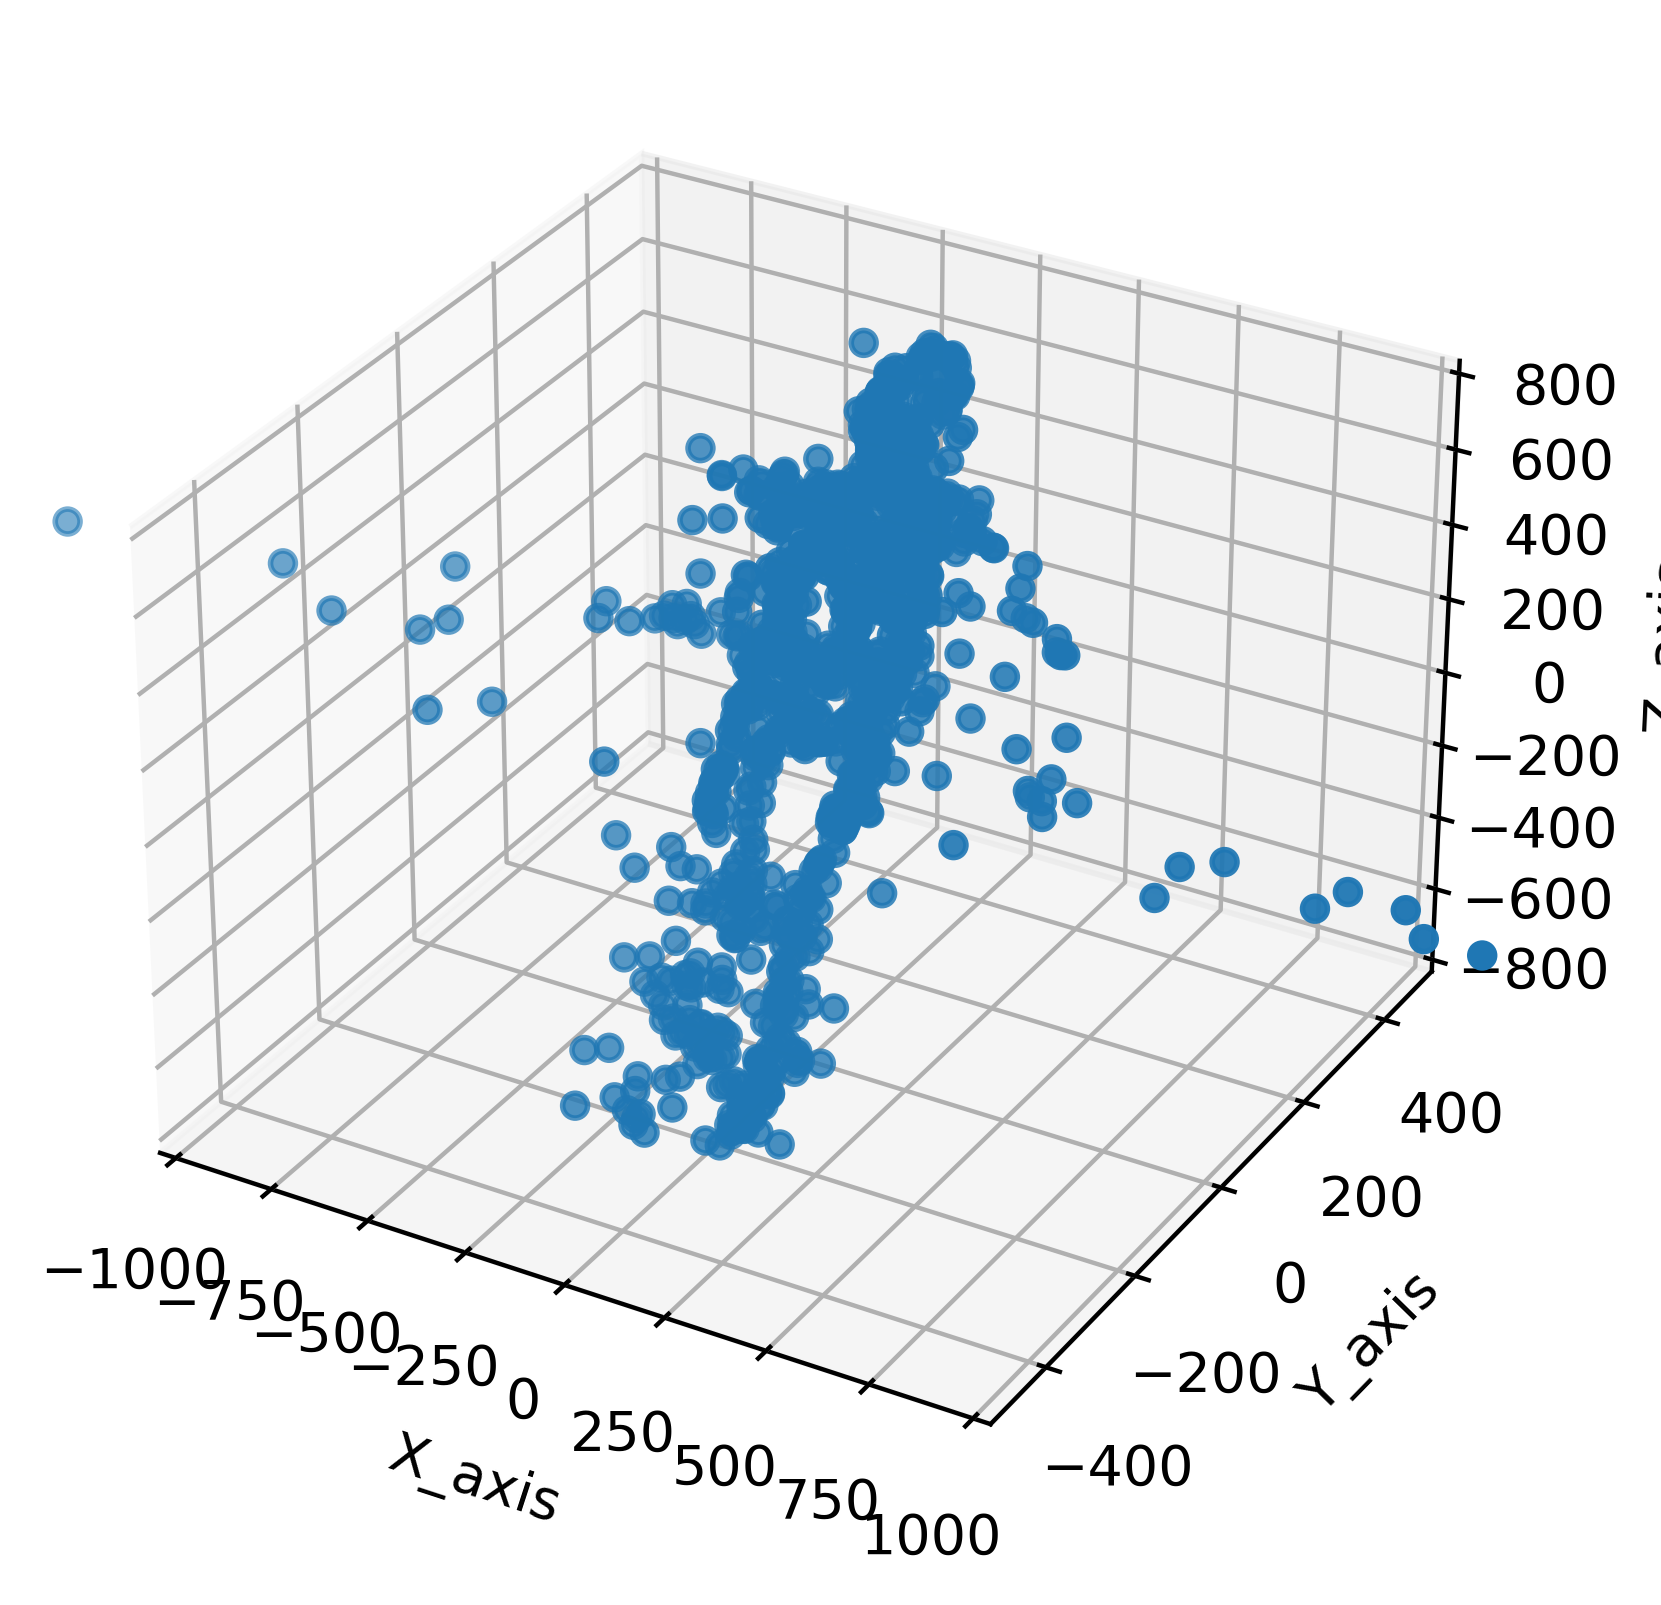

In [45]:
visualize_3D(P_3D_array_reconstructed_matched_1)

Considering only the correct matches in the correspondence list

In [46]:
P_3D_array_reconstructed_matched_2 = []
outlier_pts = 0

for point_idx in range(len(match_list)):
    optimal_P, scaling_factor = linear_eigen_method(p_array_2d_dict[cam_1_index]['Data'][match_list[point_idx][0]]['2D'][0][0], 
                                    p_array_2d_dict[cam_1_index]['Data'][match_list[point_idx][0]]['2D'][1][0], 
                                    p_array_2d_dict[cam_2_index]['Data'][match_list[point_idx][1]]['2D'][0][0], 
                                    p_array_2d_dict[cam_2_index]['Data'][match_list[point_idx][1]]['2D'][1][0], 
                                    M_camera_1, M_camera_2)

    P_3D_array_reconstructed_matched_2.append(optimal_P.flatten())

P_3D_array_reconstructed_matched_2 = np.array(P_3D_array_reconstructed_matched_2)

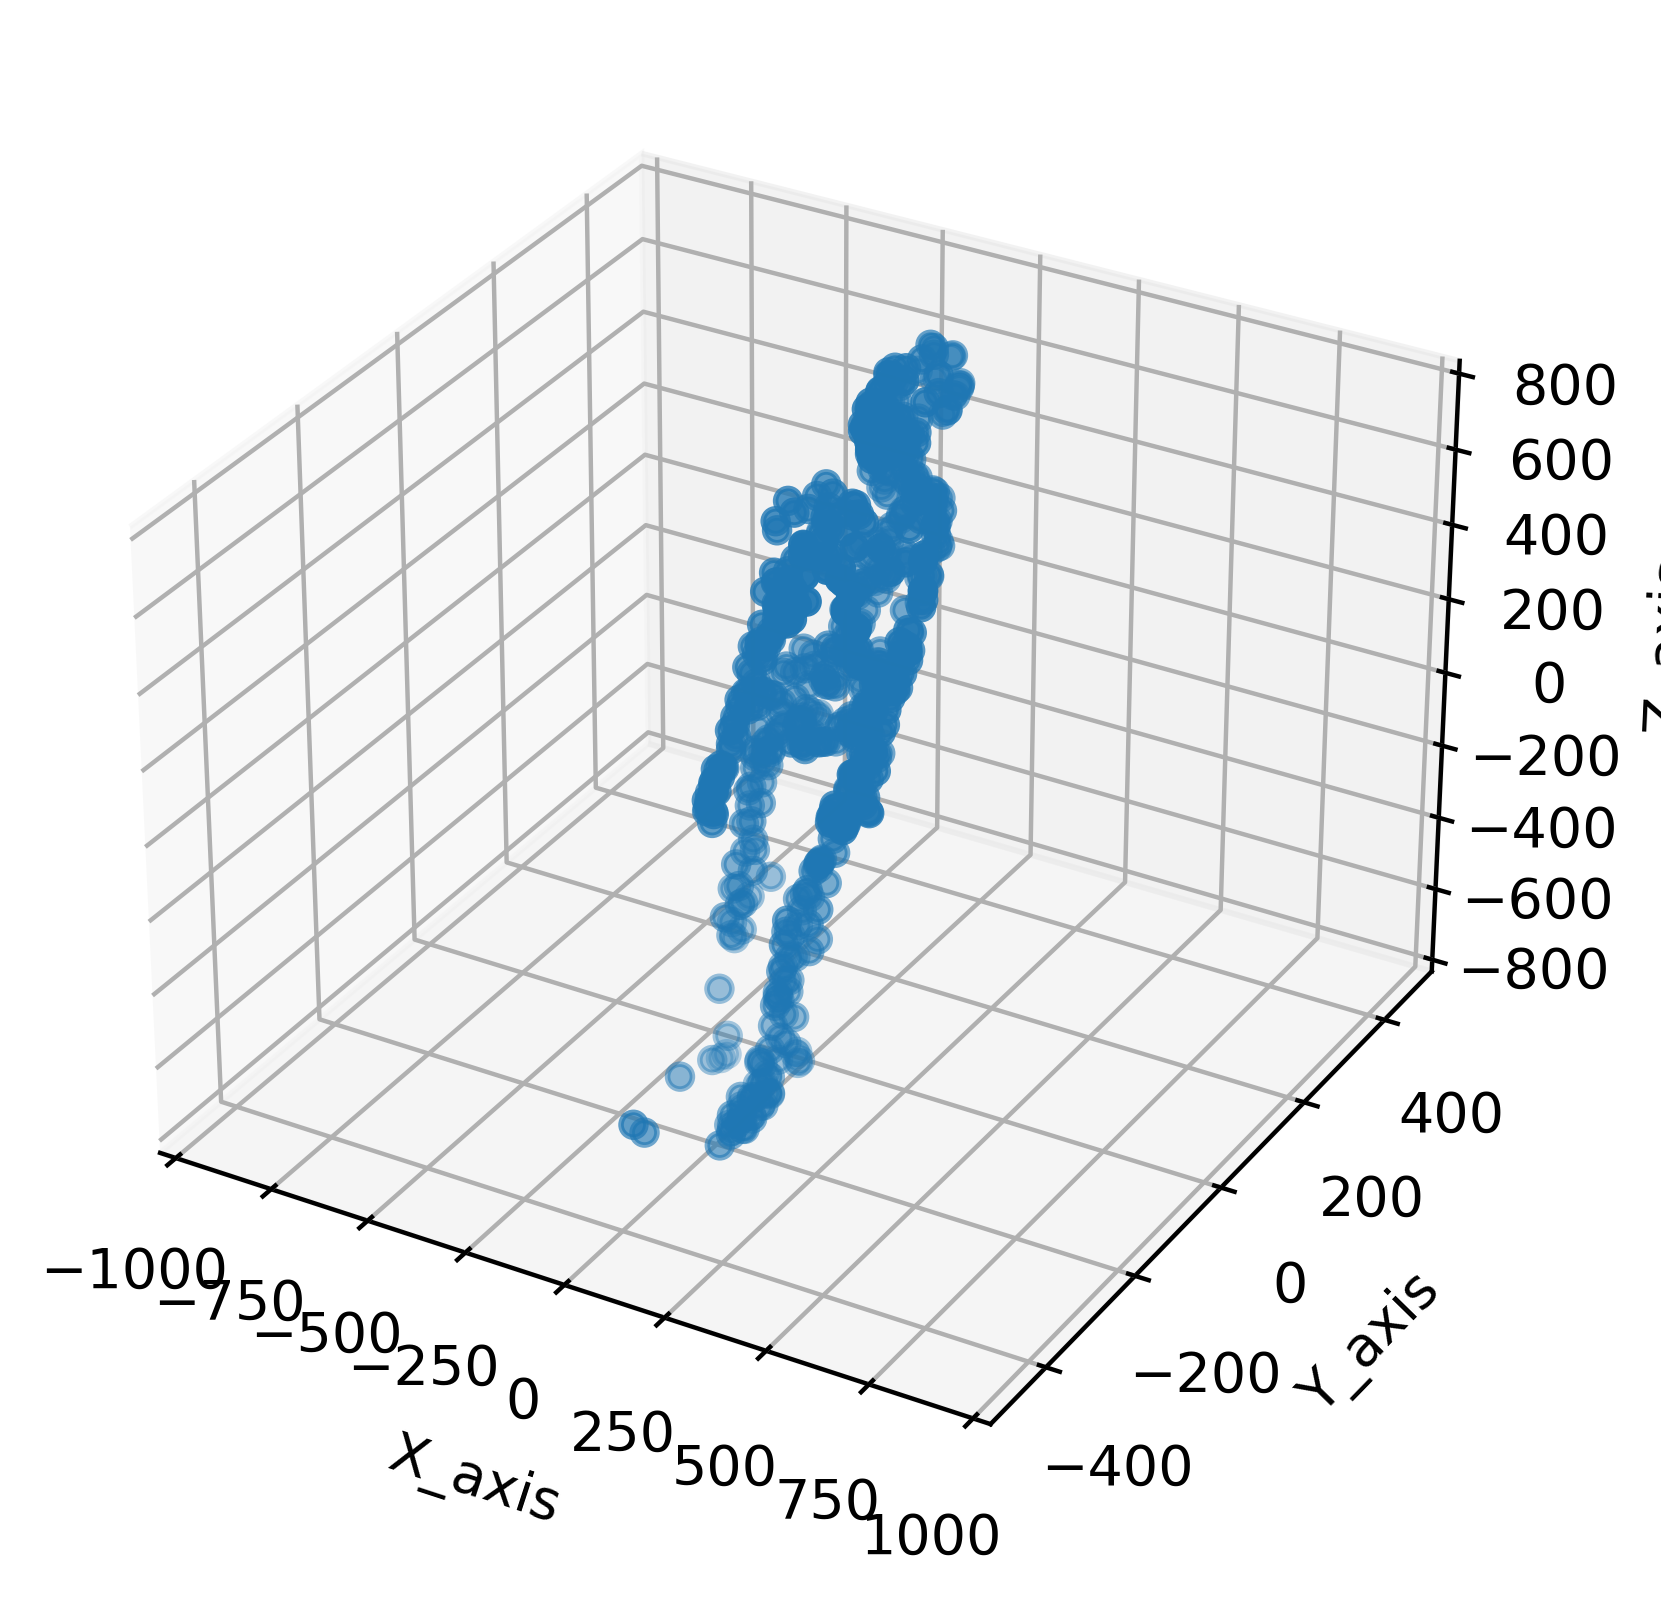

In [47]:
visualize_3D(P_3D_array_reconstructed_matched_2)

With actual matches

In [48]:
P_3D_array_reconstructed_actual = []
for point_idx in range(num_points):
    P_3D_temp, scaling_factor = linear_eigen_method(p_array_2d_dict[cam_1_index]['Data'][point_idx]['2D'][0][0], 
                                       p_array_2d_dict[cam_1_index]['Data'][point_idx]['2D'][1][0], 
                                       p_array_2d_dict[cam_2_index]['Data'][point_idx]['2D'][0][0], 
                                       p_array_2d_dict[cam_2_index]['Data'][point_idx]['2D'][1][0], 
                                       M_camera_1, M_camera_2)
    
    P_3D_array_reconstructed_actual.append(P_3D_temp.flatten())

P_3D_array_reconstructed_actual = np.array(P_3D_array_reconstructed_actual)

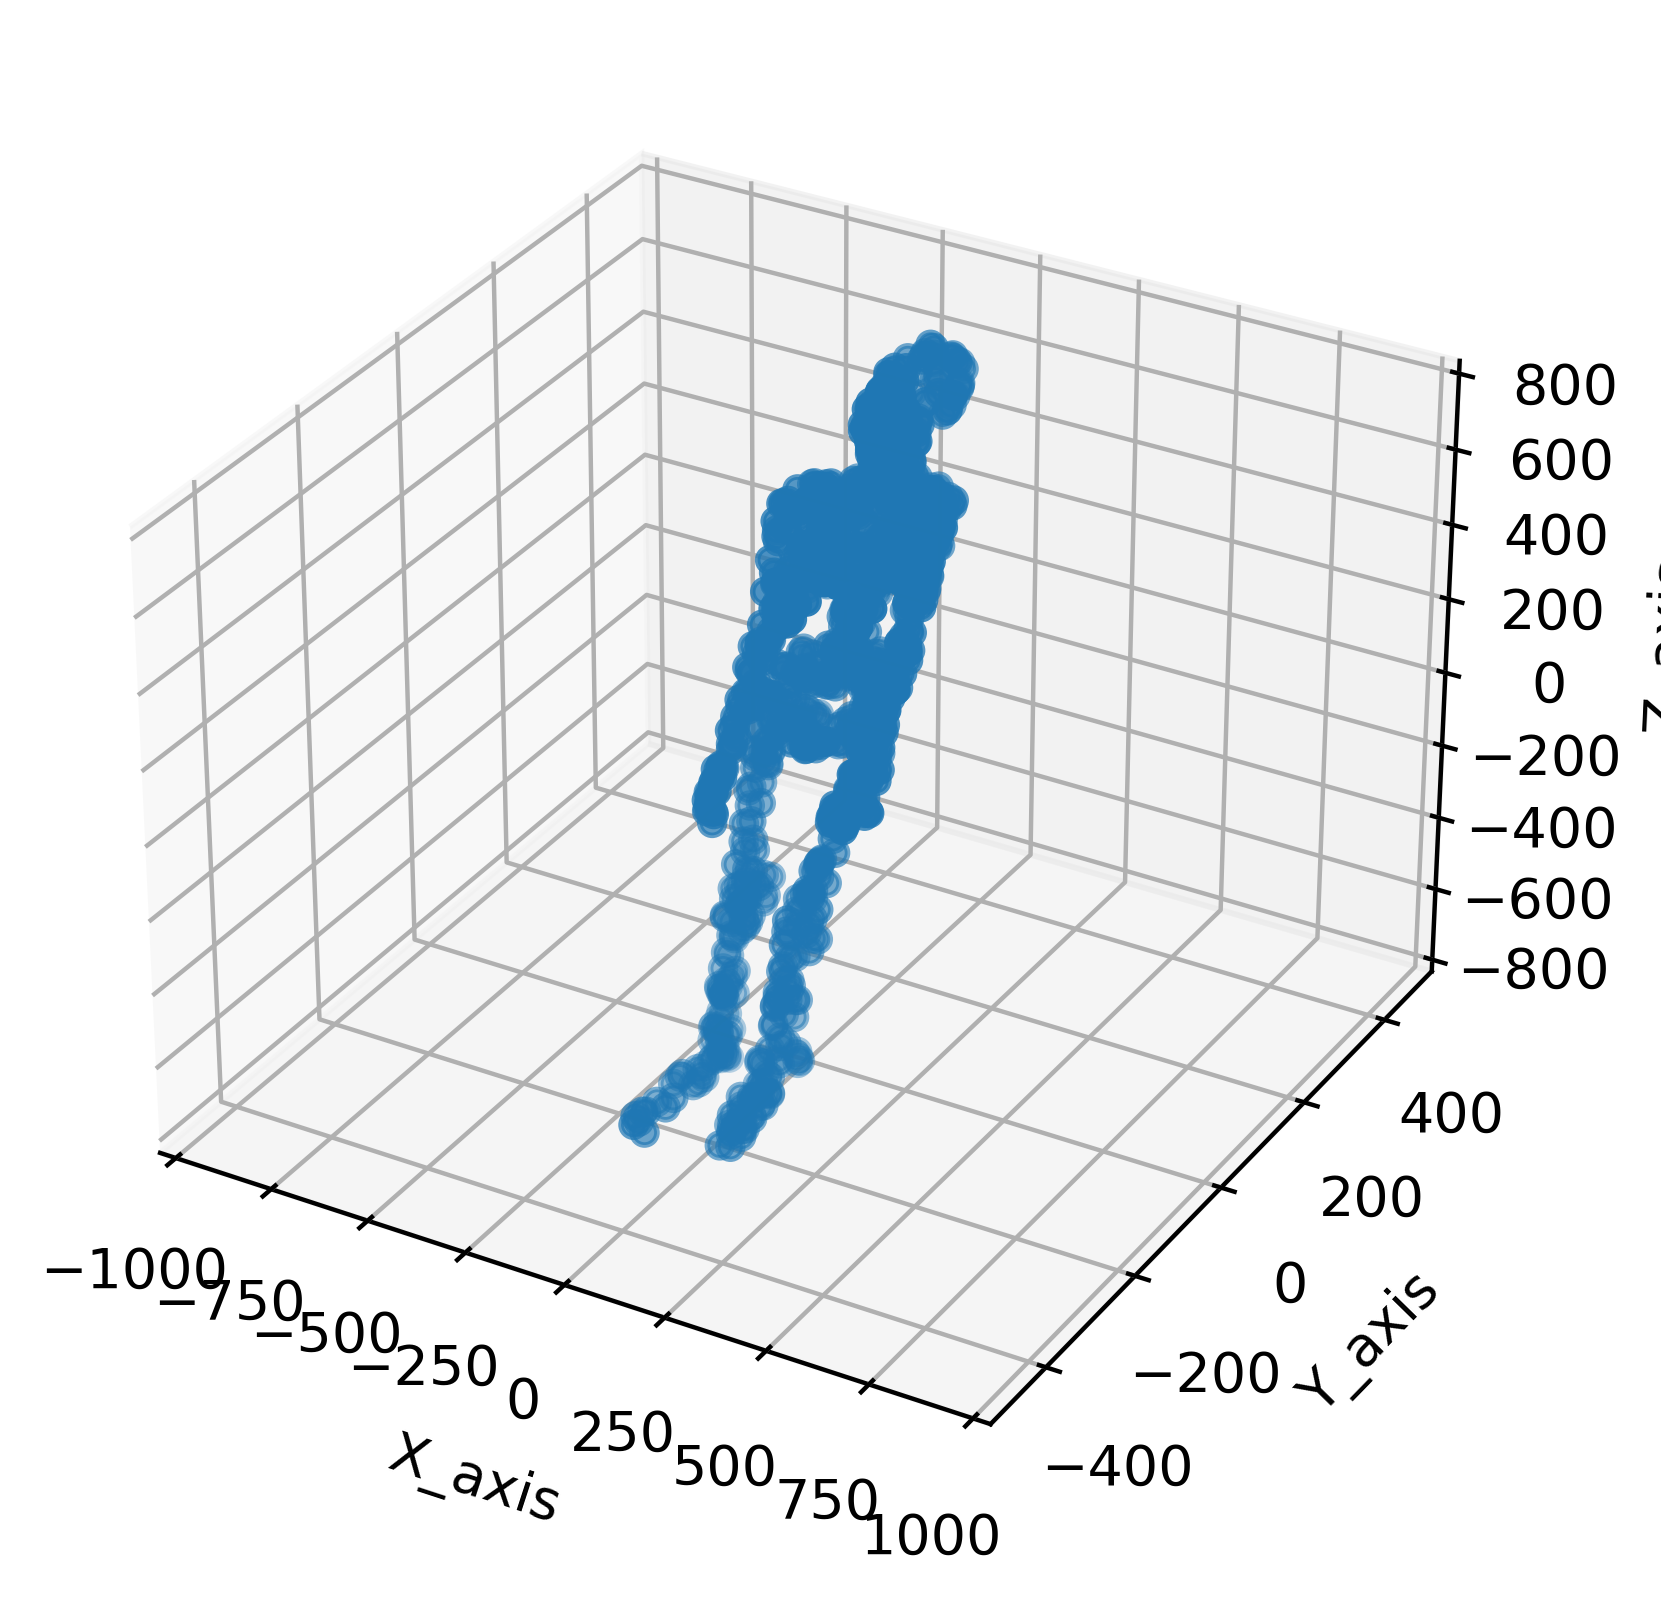

In [49]:
visualize_3D(P_3D_array_reconstructed_actual)

Save Data to PKL

In [50]:
homography_dict = {'RANSAC': robust_homography_estimate_matrix, 
                   'Projective-ICP': refined_homography}

point_correspondence_dict = {'Projective-ICP': projective_correspondence_array}

point_3d_dict = {'Actual': P_array, 'Reconstructed_Linear_Estimate_After_PICP': P_3D_array_reconstructed_matched_1}

In [51]:
# with open('PKL/Matching/Final/homography.pkl', 'wb') as file:
#     pickle.dump(homography_dict, file)

# with open('PKL/Matching/Final/point_corrrespondence.pkl', 'wb') as file:
#     pickle.dump(point_correspondence_dict, file)

# with open('PKL/Matching/Final/point_3d.pkl', 'wb') as file:
#     pickle.dump(point_3d_dict, file)

# with open('PKL/Matching/Final/camera_dict.pkl', 'wb') as file:
#     pickle.dump(camera_dict, file)

# with open('PKL/Matching/Final/point_2d_dict.pkl', 'wb') as file:
#     pickle.dump(p_array_2d_dict, file)